## <span style="color:blue">Code groups: assessing regional litter survey results. Support text for presentation </span>

### <span style="color:#008891">Methods</span>
1. data collection
2. scope

### <span style="color:#008891">Summary data</span>
#### <span style="color:#008891">All surveys</span>

1. all data
2. project lakes

### <span style="color:#008891">Code groups</span>

1. summary data
2. components
3. survey results
4. monthly median and change
5. key values by lake

#### <span style="color:#008891">Code groups: Significant events</span>

1. definition
2. significant events per lake
3. frequency of ocurrence per group and lake

#### <span style="color:#008891">Regional assessment tool</span>

Find the locations on one lake that may be hotspots for litter accumulation. Identify the ones that may be interesting to monitor in the future. Use the provided graphic and map to make your decision.
    
    

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# convenience functions for tables
def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)
# variables/arrays that are frequently used:
# project lakes

the_lakes = [
    "Bielersee",
    "Walensee",
    "Lac Léman",
    "Zurichsee",
    "Neuenburgersee",
    "Thunersee",
    "Lago Maggiore",
    "Brienzersee",
]

# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...
# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':14}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}
label45r = {'rotation':45, 'ha':'right'}
label45c = {'rotation':45, 'ha':'center'}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100

In [2]:
# the local file structure. The resources are located in the corresponding directory.
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# define a code group, there are predefined code groups in
# the resources folder under mlwcodedefs
const = ut.json_file_get(F"{output}/code_groups/construction.json")
micro = ut.json_file_get(F"{output}/code_groups/codeListMicros.json")
steps = ut.json_file_get(F"{output}/code_groups/wastewater.json")
kiosk = ['G27','G35', 'G30', 'G25','G31','G32','G33','G34', 'G21', 'G24']
constoragg =  [
"G13",
"G14",
"G15",
"G16", 
"G18", 
"G38", 
"G41",
"G67",
"G161",
"G168",
"G170",
"G171",
"G172",
"G187",
"G191",
"G192",
"G204",
"G919", 
"G934"
]
ag = ["G36", "G936", "G937", "G943"]
# diffusion = ['G74', 'G82', 'G81', 'G67', 'G73','G89','G30','G21','G23','G24','G22']

# decide which data to use
aggregated = False

# assign names to codegroups
group_one = steps
group_one_name = "waste water"
code = "step"

group_two = micro
group_two_name = 'less than 5mm'
code = "micro"

group_three = const
group_three_name = 'construction'
code = "const"

group_four = kiosk
group_four_name = 'kiosk'
code = "kiosk"

group_five = constoragg
group_five_name = 'agg or const'
code = "indus"

group_six = ag
group_six_name = 'agriculture'
code = "agg"

# group_seven = diffusion
# group_seven_name = 'diffusion'
# code = "diff"

# collect the names:
group_names = [group_one_name, group_two_name, group_three_name, group_four_name, group_five_name, group_six_name]

# collect the codes
accounted = group_one + group_two + group_three + group_four + group_five + group_six

# keep track of the figures you produce
table_num = 1
figure_num = 1
map_num = 1

# choose a lake:
lake = 'Lac Léman'

# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'codegroupsummaryfeb2020'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# probably want to keep these... the works already done
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

cols_to_keep = ['loc_date',
                'location',
                'water_name',
                'date',
                'population',
                'streets',
                'buildings',
                'rivs',
                'pop_builds',
                'pop_streets',
                'streets_builds',                
               ]

# geo data: explantory variables, index by slug and make a map:
dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['surface']
dfRivs = pd.read_csv(F"{geo_data}/exp_variables/riparian_intersects.csv", index_col='slug')['NUMPOINTS']

# restrict to lakes only
# aggregated to the parent code, which is an MLW code
dfS = dfAgg.loc[(dfAgg.water_name.isin(the_lakes))&(dfAgg.date >= start_date)].copy()
dfS['loc_date'] = zip(dfS.location,dfS.date)

# these values are not aggregated:
dfNag = dfSurveys.copy()
thesecols = ['loc_date',
             'location',
             'water_name',
             'date']

# there are somecodes that allways need to be aggregated:
dfNagl = dfNag.copy()
mapG82 = dfNagl[dfNagl.code.isin(['G82', 'G912'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG82['code'] = 'G82'
mapG81 = dfNagl[dfNagl.code.isin(['G81', 'G911'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG81['code'] = 'G81'
mapG74 = dfNagl[dfNagl.code.isin(['G74', 'G910', 'G909'])].groupby(thesecols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
mapG74['code'] = 'G74'
dfnofoam = dfNag.loc[~dfNag.code.isin(['G82', 'G912','G81', 'G911','G74', 'G910', 'G909'])]
newdf = pd.concat([dfnofoam,mapG74,mapG81,mapG82])
newdfx = newdf.copy()

# this is the df that the analysis is based on:
newdf = newdf.loc[(newdf.water_name.isin(the_lakes))&(newdf.date >= start_date)]

# map geo values to aggregated survey results:
dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])
dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x])
dfS['pop_streets'] = dfS.population + dfS.streets
dfS['pop_builds'] = dfS.population + dfS.buildings
dfS['streets_builds'] = dfS.streets + dfS.rivs

# map geo values to non aggregated survey results:
newdf['population']=newdf.location.map(lambda x: dfBeaches.loc[x]['population'])
newdf['streets'] = newdf.location.map(lambda x: dfStreets.loc[x])
newdf['buildings'] = newdf.location.map(lambda x: dfBlds.loc[x])
newdf['rivs'] = newdf.location.map(lambda x: dfRivs.loc[x])
newdf['pop_streets'] = newdf.population + newdf.streets
newdf['pop_builds'] = newdf.population + newdf.buildings
newdf['streets_builds'] = newdf.streets + newdf.buildings

# get a list of the codes in the current data
codes_in_use = dfS.code.unique()

if aggregated:
    print("Using aggregated data")
    useThis = dfS.copy()
else:
    print("Using non aggregated data")
    useThis = newdf.copy()

the_rest = [x for x in codes_in_use if x not in accounted]    
group_seven = the_rest
group_seven_name = 'the rest'
code = "rest"

group_names.append(group_seven_name)

# make the dfs according to group using the selected data
dfGone = useThis.loc[useThis.code.isin(group_one)].copy()
dfGone['groupname'] = group_one_name
dfGtwo = useThis.loc[useThis.code.isin(group_two)].copy()
dfGtwo['groupname'] = group_two_name
dfGthree = useThis.loc[useThis.code.isin(group_three)].copy()
dfGthree['groupname'] = group_three_name
dfGfour = useThis.loc[useThis.code.isin(group_four)].copy()
dfGfour['groupname'] = group_four_name
dfGfive = useThis.loc[useThis.code.isin(group_five)].copy()
dfGfive['groupname'] = group_five_name
dfGsix = useThis.loc[useThis.code.isin(group_six)].copy()
dfGsix['groupname'] = group_six_name
dfGseven = useThis.loc[useThis.code.isin(group_seven)].copy()
dfGseven['groupname'] = group_seven_name
cols_to_keep.append('groupname')

# gather up the created dataframes
groupdfs = [dfGone,dfGtwo, dfGthree, dfGfour, dfGfive, dfGsix, dfGseven]



# keep track of the files you are exporting:
files_generated = []

# method to save
def add_output(a_name, a_tag, atype="table", fignum=0, a_list=files_generated):
    tableonefile = F"{project_directory}/{a_name}"
    files_generated.append({'tag':a_tag, 'number':fignum, 'file':tableonefile,'type':atype})
    plt.savefig(tableonefile, dpi=300)

# save files
survey_csv = F"{project_directory}/survey_data.csv"
files_generated.append(survey_csv)
useThis.to_csv(survey_csv, index=False)

beaches_csv = F"{project_directory}/beach_data.csv"
files_generated.append(beaches_csv)
dfBeaches.to_csv(beaches_csv, index=False)

# put the dfs in a dictionary and key to group name
groupdfs = {x:groupdfs[i] for i,x in enumerate(group_names)}

# get the daily total for each group and store in a data frame:
for name in group_names:
    new_name = F"{name}_dt"
    dtdf = groupdfs[name].groupby(cols_to_keep, as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})    
    dtdf.set_index('loc_date', inplace=True)
    groupdfs.update({new_name:dtdf})


# get each survey total per location and date (all codes included)
# we can check combined values with this
allDf = useThis.groupby(['loc_date','location','water_name', 'date','population','streets','buildings','rivs'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
allDf.set_index('loc_date', inplace=True)

# add that to the collection of dataframes
groupdfs.update({"survey total_dt":allDf})
groupkeys = groupdfs.keys()

# get the percent of survey total for each group
dt_names = [F"{name}_dt" for name in group_names]
dt_names.append("survey total_dt")
   
for name in dt_names:
    groupdfs[name]["p_total"] = groupdfs[name].index.map(lambda x: groupdfs[name].loc[x].pcs_m/groupdfs["survey total_dt"].loc[x].pcs_m)
    groupdfs[name]['p_total'] = groupdfs[name]['p_total']*100
    groupdfs[name]['p_total'] = groupdfs[name]['p_total'].round(2)

# summarize the results by lake.
# Number of locations and surveys with or without code for each lake
# Make column headers plain english make table

# place to store the summaries
regional_summaries = []

# creating a summary for each df in groupdfs

def account_for_no_vals(x, a_df):
    if x in a_df.index:
        data = a_df.loc[x].location
    else:
        data = 0
    return data
for name in dt_names:
    this_data = groupdfs[name]
    this_agg = {'loc_date':'count', 'location':'nunique', 'pcs_m':'median', 'p_total':'mean'}
    this_data.reset_index(inplace=True)
    regional_summary = this_data.groupby('water_name').agg(this_agg)
    regions = list(regional_summary.index)
    
    # the mean of all the group data 
    rs_mean = this_data.groupby('water_name').pcs_m.mean()
    
    # the number of samples with group pcs_m > 0
    regional_summary["# samps with"] = regional_summary.index.map(lambda x: F"{this_data[(this_data.water_name == x)&(this_data.pcs_m > 0)].pcs_m.count()}/{this_data[this_data.water_name == x].loc_date.nunique()}")
    
    hasGpi = this_data[this_data.quantity > 0]
    # count the number of locations with the code value per lake
    lakes_with = hasGpi[['water_name', 'location']].groupby(['water_name']).nunique('location')
    
    regional_summary['locations with'] = regional_summary.index.map(lambda x: F"{account_for_no_vals(x, lakes_with)}/{regional_summary.loc[x].location}")
    
    # rename the columns to ui style
    new_columns = {'loc_date':'# samples',
                   "locations with":"# with",
                   'location':'# locations',
                   "pcs_m":"median pcs/m",
                   "p_total":"% of daily total"
                  }
    regional_summary.rename(columns=new_columns, inplace=True)
    
    # add the pcs/m per region:
    regional_summary['mean pcs/m'] = regional_summary.index.map(lambda x: rs_mean[x])
    col_order = ["# locations", "# with","# samples", "# samps with", "median pcs/m", "mean pcs/m", "% of daily total"]
    regional_summary = regional_summary[col_order]
    
    # reset the index, we need the index for a column in the table
    regional_summary.reset_index(inplace=True)

    # make a column name for the former index:
    regional_summary.rename(columns={'water_name':'lake'}, inplace=True)

    # round any values:
    regional_summary['mean pcs/m'] = regional_summary['mean pcs/m'].round(3)
    regional_summary["median pcs/m"] = regional_summary["median pcs/m"].round(3)
    regional_summary["% of daily total"] = regional_summary["% of daily total"].round(2)
    regional_summaries.append({'data':regional_summary.values, 'cols':regional_summary.columns, 'name':name})


Using non aggregated data


In [3]:
fr_defs_codes = {
    'G95': 'Coton-tige',
    'G100': 'Médical conteneurs/tubes/ emballages',
    'G98': 'Couches - lingettes',
    'G96': 'Serviettes hygiéniques / protège-slips / tampons et ...',
    'G91': 'Porte-biomasse',
    'G133':'Préservatifs, y compris emballage',
    'G144':'Tampons',
    'G97': 'Rafraîchisseurs de toilettes',
    "G112":"Pellets industriels (GPI)",
    "G117":"polystyrène < 5mm",
    "G106":"Fragments de plastique angulaires <5mm",
    "G103":"fragments de plastique arrondis <5mm",
    "G115":"Mousse de plastique <5mm",
    "G105":"fragments de plastique subangulaires <5mm",
    "G114":"Films <5mm",
    "G118":"Petites sphères industrielles <5mm",
    "G123":"Granulés de polyuréthane < 5mm",
    "G113":"Filaments <5mm",
    "G119":"Plastique utilisateur en feuille (>1mm)",
    "G122":"Fragments de plastique ( >1mm)",
    "G107":"Boulettes cylindriques < 5mm",
    "G108":"pastilles de disque <5mm",
    "G109":"Pellets plats <5mm",
    "G111":"Granulés sphéroïdes < 5mm",
    "G104":"fragments de plastique sous-arrondis <5mm",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G82":"Mousse de polystyrène ; perles/billes expansées 2,5 cm",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G89":"Déchets de construction en plastique",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G66":"sangles/bandes ; fermeture de paquet en plastique dur",
    "G921":"Carreaux et pièces de céramique",
    "G908": "Ruban ; électrique, isolant",
    "G186":"Débris industriels",
    "G93": "Colson, zip-ties",
    "G87": "Ruban adhésif, masquage/conduit/emballage",
    "G194":"Câbles, fil(s) métallique(s) souvent à l'intérieur du caoutchouc ou...",
    "G931":"Ruban adhésif pour barrière, police, construction",
    "G68":"Fragments de fibre de verre",
    "G83":"Pièces en polystyrène > 50cm",
    "G17":"Cartouche pour pistolet d'injection",
    "G174":"Bombes aérosols",
    "G190":"Bidons de peinture",
    "G188":"Autres bidons < 4 L",
    "G27": "Mégots et filtres à cigarettes", 
    "G30": "Emballages alimentaires ; emballages de bonbons, de snacks", 
    "G21": "Couvercles de bouteilles", 
    "G25": "Tabac ; emballages en plastique, conteneurs", 
    "G24" :"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique", 
    "G35": "Pailles et agitateurs", 
    "G31": "Bâtonnets de sucette", 
    "G32": "Jouets et faveurs de fête", 
    "G33": "Gobelets, couvercles, mousse à usage unique et plastique dur", 
    "G34": "Couverts, assiettes et plateaux palstique",
    "G67":"Bâche plastique industrielle",
    "G38":"Couvertures ; emballages en plastique gros calibre",
    "G204" :"Matériaux de construction ; briques, tuyaux, ciment",
    "G191" :"Fils et grillages",
    "G170" :"Bois (transformé)",
    "G161" :"Bois transformé",
    "G919" :"Clous, vis, boulons, etc.",
    "G171" :"Autre bois < 50cm",
    "G13":"Bouteilles, conteneurs, fûts pour le transport, le stockage",
    "G14": "Bouteilles d'huile moteur",
    "G172":"Autres bois > 50cm",
    "G41":"Gant industriel/professionnel",
    "G936":"Film sur les serres",
    "G937":"Appâts à phéromones pour les vignobles",
    "G943":"Clôturer l'agriculture, plastique",
    "G36":"Sacs/sacs en plastique résistant pour 25 kg ou plus",
    "G81":"Morceaux de polystyrène expansé 0,5cm - 2,5cm",
    "G30":"Emballages alimentaires ; emballages de bonbons, de snacks",
    "G67":"Feuilles industrielles",
    "G82":"Mousse de polystyrène; perles/billes expansées > 2,5 cm -",
    "G74":"Mousse de plastique pour l'isolation thermique ou ...",
    "G117": "Polystyrène expansée < 5mm",
    "G89":"Déchets de construction en plastique",
    "G21":"Couvercles de boissons",
    "G24":"Couvercle/anneaux de fermeture de bouteilles/récipients en plastique",
    "G23":"Couvercles non identifiés",
    "G73":"Articles et pièces en mousse (sans emballage ou... liés)",
    "G22":"Couvercles pour produits chimiques, détergents (non alimentaires)",
    "G78":"Plastiques fragmentés .5mm < x < 25mm",
    "G79":"Plastiques fragmentés x > 25mm",
    "G200":"verre brisé ",
    "G10":"Emballage fast food"
}

In [4]:
# make a table for key statistics:
somdata = groupdfs['survey total_dt']
a_sum = pd.DataFrame(somdata.pcs_m.describe()[1:].round(2)).T
a_sum_table = [[x] for x in a_sum.values[0]]
rowLabels = [x for x in list(a_sum.columns)]


def map_to_group_type(x):
    if x in ['diffusion','less than 5mm']:
        thistype = 'phys'
    else:
        thistype = 'econ'
    return thistype
limit=50
def count_k(a_string, limit):
    split = a_string.split(" ")
    total = 0
    new_words = []
    for i,word in enumerate(split):
        if (total + len(word))+1 >= limit:
            thisnewword = F"{split[i-1]}..."
            if (len(thisnewword) + total) <= limit:
                del new_words[-1]
                new_words.append(thisnewword)
            else:
                continue
        else:
            total += len(word)+1
            new_words.append(word)

    return " ".join(new_words)

colors = ['dodgerblue', 'salmon', 'teal', 'red','maroon','goldenrod', 'mediumspringgreen']
grouppalette = {x:colors[i] for i,x in enumerate(group_names)}


is_french = False
is_german = False
is_italian = False
french_names = {
    "waste water":"traitement d'eau",
    "less than 5mm":"moins que 5mm",
    "construction":"construction",
    "kiosk":"kiosque",
    "agg or const":"construction et agriculture",
    "agriculture":"agriculture",
    "the rest":"le rest",
    
}

french_sum_names = {"survey total":"total de l'enquête", **french_names}
thing = 'objets'
parent = "de l'ensemble"
french_pcm = "pièces par mètre"
french_srs = "résultats des recensements"
french_pcg = "par groupe de codes"
french_pct = "pourcentage du total"
french_med = "médian"
french_mm = "médiane mensuelle"
french_change = 'changement'
french_bg = "par groupe"
french_nooutliers = "les valeurs extrêmes ne sont pas indiquées"
french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité'}
of_prep= 'de'
frname = [v for k,v in french_names.items()]
frpalette = {french_names[x]:grouppalette[x] for x in grouppalette}
summary_row_fr = ['moy', 'et', 'min', '25%', '50%', '75%', 'max']
french_key_values = "valeurs clés"


In [5]:
if is_french:    
    sommarkdown = """### <span style='color:#1e90ff'>Méthodes</span>\n#### <span style='color:#008891'>Source des données, calendrier, portée géographique et méthodes de collecte</span>\n
    Les données utilisées pour cette analyse sont les résultats d'enquêtes sur les déchets de plage menées en Suisse. Toutes les enquêtes qui ont été menées sur le lac de Bienne, le lac de Neuchâtel, le lac de Thoune, le lac Walensee, le lac de Zurich, le lac Léman, le lac Brienze et le lac Magiore ont été prises en compte.\n
    Les données ont été collectées selon le protocole décrit ici https://www.plagespropres.ch/. En bref, toutes les déchets visibles sont collectées le long d'une plage à une distance mesurée du bord de l'eau. La largeur de la zone d'étude dépend du terrain et du niveau de l'eau. La ligne de rive visible ou la structure physique la plus proche définit la largeur d'une enquête.\n
    Des enquêtes ont été menées par:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    Cette analyse est un document open source. Le cahier de notes de travail est disponible dans le dépôt situé ici: https://github.com/hammerdirt-analyst/iqals.\n
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff">Methods</span>\n#### <span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>\n
    The data for this analysis is the results from beach-litter surveys conducted in Switzerland.\n
    All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered.\n 
    The data was collected according to the protocol described here https://www.plagespropres.ch/. In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.\n
    Surveys were conducted by the following organizations:\n
    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?\n
    This analysis is an open source document. The working note book is available in the repository located here https://github.com/hammerdirt-analyst/iqals.\n

    """

In [6]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff">Methods</span>
#### <span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>

    The data for this analysis is the results from beach-litter surveys conducted in Switzerland.

    All surveys that were conducted on Bielersee, Neuenburgersee, Thunersee, Walensee, Zurichsee, Lac Léman, Brienzersee and Lago Magiore were considered.
 
    The data was collected according to the protocol described here https://www.plagespropres.ch/. In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.

    Surveys were conducted by the following organizations:

    1. hammerdirt
    2. Association pour le Sauvegarde du leman
    3. Solid Waste Management Ecole Polytechnique Federal
    4. Ecole International de Geneve
    5. Precious plastic leman
    6. Why isn't your association here?

    This analysis is an open source document. The working note book is available in the repository located here https://github.com/hammerdirt-analyst/iqals.


    

In [7]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Champ d'application</span>\n
    Le champ d'application des enquêtes comprend les niveaux de population totale et la configuration de l'utilisation des sols pour la municipalité environante. L'utilisation des sols est quantifiée en calculant la superficie au sol en m² attribuée aux bâtiments dans un rayon de 500 m du lieu de l'enquête et la longueur totale en mètres des routes dans un rayon de 1000 m du lieu de l'enquête*.\n
    Les résultats et les lieux d'enquête peuvent être classés selon les attributs suivants:\n
    1. M² de surface au sol des bâtiments situés dans un rayon de 500m du lieu d'enquête
    2. Longueur totale des rues/routes dans un rayon de 1000 m de l'enquête
    3. Nombre d'intersections de rivières/canaux dans un rayon de 1500m de l'étude
    3. Population de la commune environnante\n
    *Les valeurs sont calculées en utilisant: https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D\n
    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Scope of surveys</span>\n
    The scope of the surveys includes the total population levels and land use configuration for the adjacent municipality. Land use is quantified by calculating the m² of space attributed to buildings wtihin 500m of the survey location and the total length in meters of roads within 1000m of the survey location*.\n
    The results and survey locations can be classified according to the following attributes:\n
    1. M² of buildings within 500m of the survey
    2. Total length of streets/roads within 1000m of the survey
    3. Number of river/canal intersections within 1500m of the survey
    3. Population of the surounding municipality\n
    *Values are calculated using https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D\n
    
    """

In [8]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Scope of surveys</span>

    The scope of the surveys includes the total population levels and land use configuration for the adjacent municipality. Land use is quantified by calculating the m² of space attributed to buildings wtihin 500m of the survey location and the total length in meters of roads within 1000m of the survey location*.

    The results and survey locations can be classified according to the following attributes:

    1. M² of buildings within 500m of the survey
    2. Total length of streets/roads within 1000m of the survey
    3. Number of river/canal intersections within 1500m of the survey
    3. Population of the surounding municipality

    *Values are calculated using https://shop.swisstopo.admin.ch/en/products/landscape/tlm3D

    
    

In [9]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Données de synthèse: toutes les enquêtes</span>\n    
    Depuis le 14 avril 2020, 301 échantillons ont été enregistrés, 266 provenant des lacs et 35 de rivières (graphique 1, tableau 1).\n    
    Le nombre d'échantillons dépasse à la fois nos attentes personnelles et les exigences du contrat. Cependant, il reste encore trois mois d'échantillonnage.\n    
    Nous remercions les personnes suivantes pour leur participation:\n
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Summary data: all surveys</span>\n    
    Since april 14, 2020 301 samples have been recorded, 266 from lakes and 35 from rivers (figure 1, table 1).\n 
    The number of samples exceeds both our personal expectations and the contract requirements. However there are still three more months of sampling.\n 
    Thanks to the following individuals for their participation:\n 
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer\n
    
    """

In [10]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Summary data: all surveys</span>
    
    Since april 14, 2020 301 samples have been recorded, 266 from lakes and 35 from rivers (figure 1, table 1).
 
    The number of samples exceeds both our personal expectations and the contract requirements. However there are still three more months of sampling.
 
    Thanks to the following individuals for their participation:
 
    1. Helen Kurukulasuriya
    2. Martin Brenvasser
    3. Adrien Bonny
    4. Debora Camaro
    5. Geatan Busser
    6. Marie-France Labelle
    7. Andreas Gauer

    
    

In [11]:
# keep track of the figures you produce
table_num = 0
figure_num = 0
map_num = 0

# use all the surveys un aggregated
allsurveys =  newdfx[newdfx.date >= '2020-04-01'].groupby(['loc_date', 'location', 'date', 'water_name'], as_index=False).pcs_m.sum()

# identify lakes v/s rivers
allsurveys['type'] = allsurveys.location.map(lambda x: dfBeaches[dfBeaches.index == x]['water'].values[0])

# count the number of rivers and lakes
v_counts = allsurveys['type'].value_counts()
rivercount = int(v_counts['r'])
lakecount = int(v_counts['l'])

# make a table for key statistics:
a_sum = pd.DataFrame(allsurveys.pcs_m.describe()[1:].round(2)).T
a_sum_table = [[x] for x in a_sum.values[0]]
rowLabels = [x for x in list(a_sum.columns)]

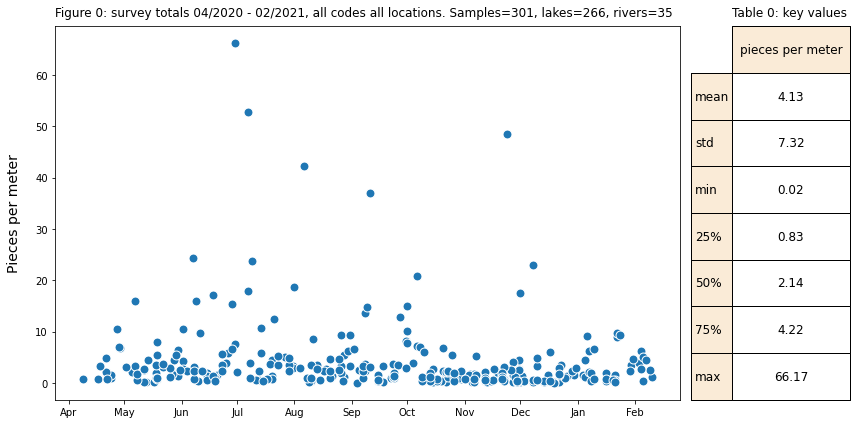

In [12]:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')

fig = plt.figure(constrained_layout = False, figsize=(12,6))
gs = GridSpec(1, 5, figure=fig)

ax1 = fig.add_subplot(gs[4:])

a_table = mpl.table.table(
    cellText=a_sum_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=['pieces per meter'],
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)
table_fonts(a_table, size=12)
make_table_grids(ax1)

ax1.add_table(a_table )
ax1.tick_params(**tabtickp_k)
ax1.set_title(F"Table {table_num}: key values", loc='left', pad=10)

table_num += 1


ax2 = fig.add_subplot(gs[0:4])
sns.scatterplot(data=allsurveys, x='date',  y='pcs_m', alpha=1, linewidth=1,s=80, ax=ax2)
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(allmonths)
ax2.set_ylabel("Pieces per meter", **ylab_k)
ax2.set_title(F"Figure {figure_num}: survey totals {startyearmonth} - {endyearmonth}, all codes all locations. Samples={len(allsurveys)}, lakes={lakecount}, rivers={rivercount}", loc='left', pad=10)
ax2.set_xlabel("")



figure_num += 1
fignum = figure_num
plt.tight_layout()
figname = "tableonefigureone.jpg"
atype = "figure"


add_output(figname,  'all surveys: scatter plot, key values table', fignum=fignum, atype=atype)

plt.show()

In [13]:
if is_french:
    sommarkdown = """#### <span style="color:#008891"> Les objets les plus communs: toutes les enquêtes </span>\n    
    Si l'on considère les totaux d'objets, sans référence à la localisation de l'échantillon, environ 65% du total peut être expliqué avec 12 types d'objets (tableau 2).\n
    Les mousses représentent environ 15 % du total (G81, G82, G74 et G117), soit à peu près la même chose que les mégots de cigarettes.\n
    Les plastiques fragmentés non identifiés (G79, G78) représentent ~ 12 % du total.\n
    Deux types d'objets sont considérés comme des microplastiques : G112 et G117, ~ 5% du total.\n
    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Most common objects: all surveys</span>\n    
    Considering the object totals, without reference to sample location,  approximately 65% of the total can be accounted for with 12 object types (table 2).\n    
    Foams account for ~15% of the total (G81, G82, G74 and G117), this is about the same as cigarette butts.\n    
    Unidentified fragmented plastics (G79, G78) represent ~ 12% of the total\n    
    Two object types are considered microplastic: G112 and G117, ~ 5% of the total\n
    
    """

In [14]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Most common objects: all surveys</span>
    
    Considering the object totals, without reference to sample location,  approximately 65% of the total can be accounted for with 12 object types (table 2).
    
    Foams account for ~15% of the total (G81, G82, G74 and G117), this is about the same as cigarette butts.
    
    Unidentified fragmented plastics (G79, G78) represent ~ 12% of the total
    
    Two object types are considered microplastic: G112 and G117, ~ 5% of the total

    
    

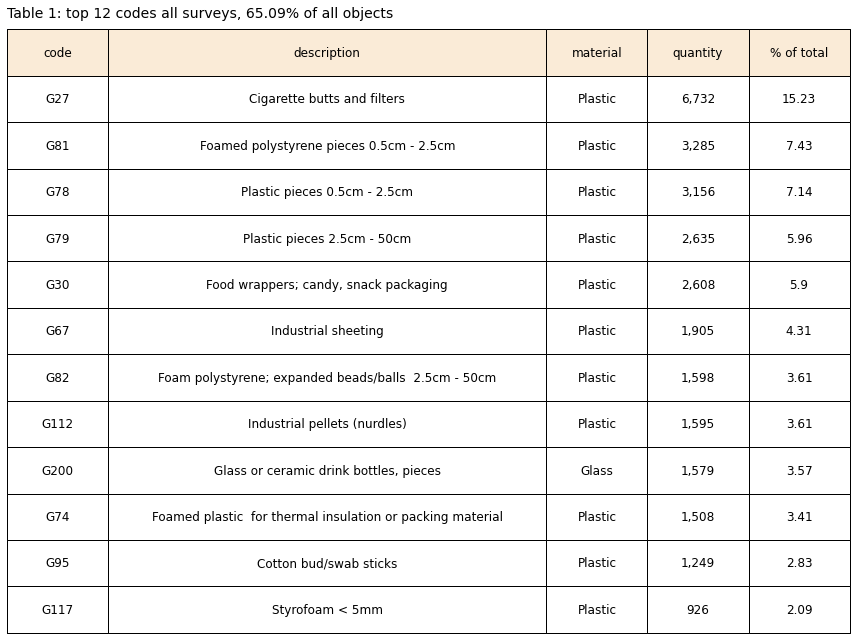

In [15]:
# get the total quantity for each code
allcodevals = pd.DataFrame(newdfx[newdfx.date >= '2020-04-01'].groupby('code').quantity.sum())

# add description and material from the codes df
allcodevals['description'] = allcodevals.index.map(lambda x: dfCodes.loc[x].description)
allcodevals['material'] = allcodevals.index.map(lambda x: dfCodes.loc[x].material)

# get the total number of objects and the percent of total
allcodevalst= allcodevals.quantity.sum()
allcodevals['p_total'] = allcodevals.quantity/allcodevalst*100
allcodevals['p_total'] = allcodevals['p_total'].round(2)

ptotal = allcodevals['p_total'].sum()

# sort the values 
allcodevals = allcodevals.sort_values(by='quantity',ascending=False)

# do some housekeeping
allcodevals.rename(columns={'p_total':'% of total'}, inplace=True)
allcodevals = allcodevals[['description', 'material', 'quantity', '% of total']]

# format for charting
allcodevals.reset_index(inplace=True)
allcodevals['quantity'] = allcodevals.quantity.apply(lambda x: "{:,}".format(x))

# define the most common objects:
tabledata = allcodevals[allcodevals['% of total'] >= 2]

# sum the % of total of the most common objects
ptotal = tabledata['% of total'].sum()

# make adjustments to table kwargs:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[12,52, 12, 12, 12], cellLoc='center')

# plot the table:
fig, ax = plt.subplots(figsize=(12, len(tabledata)*.75))
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=tabledata.values,
    colLabels=tabledata.columns,
    colColours=['antiquewhite' for col in list(tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

table_fonts(a_table, size=12)

ax.add_table(a_table)
ax.tick_params(**tabtickp_k)
ax.set_title(F"Table {table_num}: top {len(tabledata)} codes all surveys, {np.round(ptotal, 2)}% of all objects", **title_k14)

figname = F"table{table_num}.jpg"

table_num += 1
fignum=table_num
plt.tight_layout()
figname = "tabletwo.jpg"
add_output(figname, 'all surveys: most common objects table', fignum=fignum)
plt.show()
plt.close()

In [16]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Données de synthèse sur les lacs du projet </span>\n
    
    Il y a 8 lacs concernés par le projet:\n

    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Lac de Neuchâtel
    7. Walensee
    8. Brienzersee\n

    Le lac de Brienze a été ajouté à la liste des lacs étudiés, en raison de sa position dans le bassin versant de l'Aare (graphique 2, tableau 3).
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Project lakes summary data </span>\n
    
    There are eight project lakes:\n

    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Neuenburgersee
    7. Walensee
    8. Brienzersee\n

    Brienzersee was added to the surveys beacuase of it's position in the catchment area of the Aare (figure 2, table 3).
    
    """
    

In [17]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Project lakes summary data </span>

    
    There are eight project lakes:


    1. Zurichsee
    2. Lago Maggiore
    3. Thunersee
    4. Lac Léman
    5. Bielersee
    6. Neuenburgersee
    7. Walensee
    8. Brienzersee


    Brienzersee was added to the surveys beacuase of it's position in the catchment area of the Aare (figure 2, table 3).
    
    

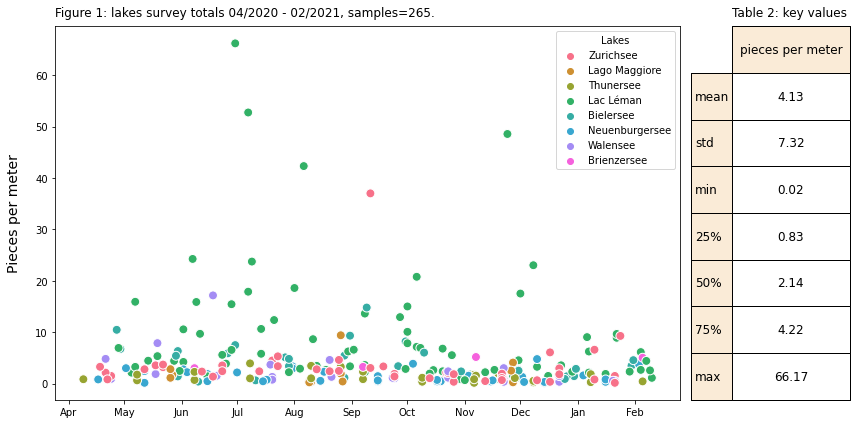

In [18]:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), cellLoc='center')

fig = plt.figure(constrained_layout = False, figsize=(12,6))
gs = GridSpec(1, 5, figure=fig)

ax1 = fig.add_subplot(gs[4:])

if is_french:
    rowLabels = summary_row_fr
    col_label = [french_pcm]
else:
    col_label = ['pieces per meter']

a_table = mpl.table.table(
    cellText=a_sum_table,
    rowLabels=rowLabels,
    rowColours=['antiquewhite' for i in rowLabels],
    colLabels=col_label,
    colColours=['antiquewhite' for col in np.arange(1)],
    
    ax=ax1,
    **tablecenter_k)

table_fonts(a_table, size=12)
make_table_grids(ax1)

ax1.add_table(a_table )
ax1.tick_params(**tabtickp_k)
if is_french:
    ax1.set_title(F"Table {table_num}: {french_key_values}", loc='left', pad=10)
else:
    ax1.set_title(F"Table {table_num}: key values", loc='left', pad=10)
    
table_num += 1


ax2 = fig.add_subplot(gs[0:4])
sns.scatterplot(data=somdata, x='date',  y='pcs_m', hue='water_name', palette='husl', alpha=1, linewidth=1,s=80, ax=ax2)
ax2.xaxis.set_major_formatter(mths_fmt)
ax2.xaxis.set_major_locator(allmonths)
ax2.set_ylabel("Pieces per meter", **ylab_k)
if is_french:
    ax2.set_title(F"Figure {figure_num}: {french_srs} {startyearmonth} - {endyearmonth}, samples={len(somdata)}.", loc='left', pad=10)
    ax2.set_ylabel(F"{french_pcm}", **ylab_k)
    
else:
    ax2.set_title(F"Figure {figure_num}: lakes survey totals {startyearmonth} - {endyearmonth}, samples={len(somdata)}.", loc='left', pad=10)
ax2.set_xlabel("")
ax2.legend(title="Lakes")


figure_num += 1
fignum = figure_num
plt.tight_layout()
figname = F"tablethreefiguretwo.jpg"
atype='figure'
add_output(figname, 'lake surveys: scatter plot, key values table',fignum=fignum, atype=atype)

plt.show()

In [19]:
if is_french:
    sommarkdown = """#### <span style="color:#008891"> Les objets les plus communs: les lacs du projet</span>\n
    
    Les lacs du projet sont ceux où se trouvent la majorité des échantillons. Par conséquent, la liste des objets les plus courants ne change pas par rapport au total de tous les objets(tableau 4).
    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Most common objects: project lakes</span>\n
    
    The project lakes are where the majority of the samples are. Therefore the list  of the most common objects does not change from the total of all objects(table 4).

    """

In [20]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Most common objects: project lakes</span>

    
    The project lakes are where the majority of the samples are. Therefore the list  of the most common objects does not change from the total of all objects(table 4).

    

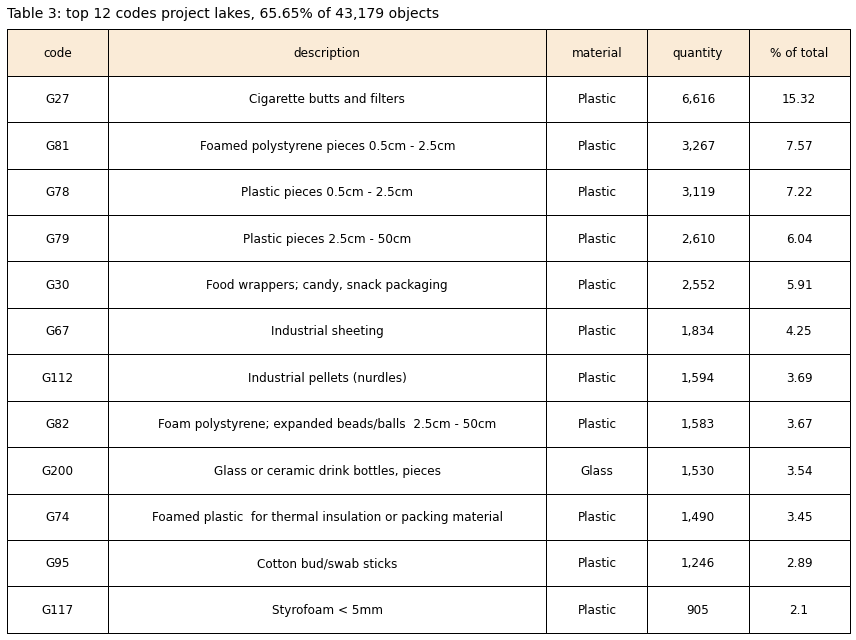

In [21]:
allcodevals = pd.DataFrame(newdf.groupby('code').quantity.sum())

# add description and material from the codes df
allcodevals['description'] = allcodevals.index.map(lambda x: dfCodes.loc[x].description)

allcodevals['material'] = allcodevals.index.map(lambda x: dfCodes.loc[x].material)

# get the total number of objects and the percent of total
allcodevalst= allcodevals.quantity.sum()
allcodevals['p_total'] = allcodevals.quantity/allcodevalst*100
allcodevals['p_total'] = allcodevals['p_total'].round(2)

# ptotal = allcodevals['p_total'].sum()

# sort the values 
allcodevals = allcodevals.sort_values(by='quantity',ascending=False)

# do some housekeeping
allcodevals.rename(columns={'p_total':'% of total'}, inplace=True)
allcodevals = allcodevals[['description', 'material', 'quantity', '% of total']]

# format for charting
allcodevals.reset_index(inplace=True)
allcodevals['quantity'] = allcodevals.quantity.apply(lambda x: "{:,}".format(x))

# define the most common objects:
tabledata = allcodevals[allcodevals['% of total'] >= 2]

# sum the % of total of the most common objects
ptotal = tabledata['% of total'].sum()

# check context
if is_french:
    tabledatacopy = tabledata.copy()
    tabledatacopy['description'] = tabledatacopy.code.map(lambda x: count_k(fr_defs_codes[x], limit))
    tabledatacopy.rename(columns=french_columns, inplace=True)
    tabledata = tabledatacopy

# make adjustments to table kwargs:
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[12,52, 12, 12, 12], cellLoc='center')

# plot the table:
fig, ax = plt.subplots(figsize=(12, len(tabledata)*.75))
ax = make_table_grids(ax)
a_table = mpl.table.table(
    cellText=tabledata.values,
    colLabels=tabledata.columns,
    colColours=['antiquewhite' for col in list(tabledata.columns)],    
    ax=ax,
    **tablecenter_k)

table_fonts(a_table, size=12)

ax.add_table(a_table)
ax.tick_params(**tabtickp_k)

# check context
if is_french:
    ax.set_title(F"Table {table_num}: top {len(tabledata)} codes des lacs du projet, {np.round(ptotal, 2)}% de {'{:,}'.format(allcodevalst)} objets", **title_k14)
    
else:
    ax.set_title(F"Table {table_num}: top {len(tabledata)} codes project lakes, {np.round(ptotal, 2)}% of {'{:,}'.format(allcodevalst)} objects", **title_k14)

figname = F"table{table_num}.jpg"
fignum=table_num
table_num += 1

plt.tight_layout()
add_output(figname, 'lake surveys: most common objects table', fignum=fignum)
plt.show()
plt.close()

In [22]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff"> Lacs du projet : objets regroupés par usage ou caractéristiques physiques</span>\n
    Nous avons défini sept groupes de codes, cinq sont regroupés par utilisation ou source et deux par caractéristiques physiques.
    
    1. installations de traitement de l'eau
    2. les objets de moins de 5 mm
    3. la construction/réparation des maisons
    4. kiosque: snacks et cigarettes
    5. ag ou const: construction et/ou agriculture
    6. l'agriculture
    7. le reste**

    **Il n'y a pas de croisement entre les groupes 'construction' (groupe trois) et 'agriculture ou construction' (groupe cinq).

    **Le reste est constitué des objets qui ne sont contenus dans aucun autre groupe.
    
    """
else:
    sommarkdown = """### <span style="color:#1e90ff"> Project lakes: objects grouped by use or physical characteristics</span>\n
    We have defined seven code groups, five are grouped by use or source and two by physical characteristics.

    1. water treatment facilities
    2. objects less than 5mm
    3. construction/home repair
    4. kiosk: snack foods and cigarettes
    5. ag: construction and/or aggriculture
    6. agriculture
    7. the rest**

    **There is no crossover between the groups 'construction' (group three) and 'agriculture  or construction' (group 5).

    **The rest group is the objects not contained in any other group.
    
    """

In [23]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff"> Project lakes: objects grouped by use or physical characteristics</span>

    We have defined seven code groups, five are grouped by use or source and two by physical characteristics.

    1. water treatment facilities
    2. objects less than 5mm
    3. construction/home repair
    4. kiosk: snack foods and cigarettes
    5. ag: construction and/or aggriculture
    6. agriculture
    7. the rest**

    **There is no crossover between the groups 'construction' (group three) and 'agriculture  or construction' (group 5).

    **The rest group is the objects not contained in any other group.
    
    

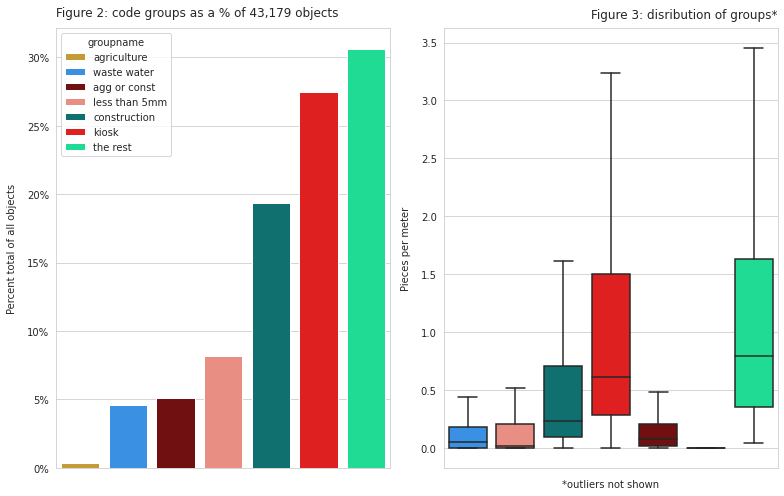

In [24]:
sns.set_style('whitegrid')
markers = ['s', 'P', 'D', 'X', 'o']
def make_ecdf(somdata, numsamps):
    vals = somdata.pcs_m.sort_values()
    valsy = [i/numsamps for i in np.arange(numsamps)]
    return vals, valsy




groupdconcat = pd.concat( [groupdfs[name] for name in dt_names[:-1]])
groupdconcat['grouptype'] = groupdconcat.groupname.map(lambda x: map_to_group_type(x))
atotal = groupdfs['survey total_dt'].quantity.sum()
groupoftotal = groupdconcat.groupby(['grouptype','groupname'], as_index=False).quantity.sum()
groupoftotal['p_total'] = (groupoftotal.quantity/atotal)*100
groupoftotal['p_total'] = groupoftotal['p_total'].round(2)
groupoftotal.sort_values(by='p_total', ascending=True, inplace=True)
anorder = groupoftotal.groupname.values

anorder = ['the rest', 'less than 5mm','kiosk', 'construction', 'agg or const', 'waste water','agriculture', ]
a_form = mtick.FormatStrFormatter('%.0f%%')



fig, ax = plt.subplots(1,2, figsize=(11, 7))
if is_french:
    groupoftotal['groupname'] = groupoftotal['groupname'].map(lambda x: french_names[x])
    groupdconcat['groupname'] = groupdconcat['groupname'].map(lambda x: french_names[x])
#     anorder = [french_names[x] for x in anorder]
    

    sns.barplot(data=groupoftotal, x='groupname', hue='groupname', palette=frpalette, y='p_total', dodge=False, ax=ax[0])
    ax[0].set_ylabel(F"{french_pct}", labelpad=10)
    ax[0].set_title(F"Figure {figure_num}: {french_bg} % {of_prep} {'{:,}'.format(atotal)} {thing}", **title_k)
    figure_num += 1
    
    sns.boxplot(data=groupdconcat, x='groupname', y='pcs_m', hue='groupname', palette=frpalette, dodge=False, ax=ax[1],  showfliers=False)
    ax[1].set_ylabel(F"{french_pcm}", labelpad=10)
    ax[1].set_title(F"Figure {figure_num}: disribution {french_bg}*", **titler_k)
    ax[1].set_xlabel(F"{french_nooutliers}")
    fignum = figure_num
    figure_num += 1
else:
    sns.barplot(data=groupoftotal, x='groupname', hue='groupname', palette=grouppalette, y='p_total', dodge=False, ax=ax[0])
    ax[0].set_ylabel("Percent total of all objects", labelpad=10)
    ax[0].set_title(F"Figure {figure_num}: code groups as a % of {'{:,}'.format(atotal)} objects", **title_k)
    ax[0].yaxis.set_major_formatter(a_form)
    ax[0].set_xlabel("")
    ax[0].set_xticklabels("")
    figure_num += 1
    
    sns.boxplot(data=groupdconcat, x='groupname', y='pcs_m', hue='groupname', palette=grouppalette, dodge=False, ax=ax[1], showfliers=False)
    ax[1].set_ylabel("Pieces per meter", labelpad=10)
    ax[1].set_title(F"Figure {figure_num}: disribution of groups*", **titler_k)
    ax[1].set_xlabel("*outliers not shown")
    ax[1].get_legend().remove()
    ax[1].set_xticklabels("")
    
    figure_num += 1
    fignum=figure_num






    
# a_form = mtick.FormatStrFormatter('%.0f%%')
# ax.yaxis.set_major_formatter(a_form)


plt.tight_layout()
figname = "figthreeandfour.jpg"
atype='figure'
add_output(figname, 'code groups: percentage of total, distribution', fignum=fignum, atype=atype)
plt.show()
plt.close()

In [25]:
if is_french:
    sommarkdown = """#### <span style="color:#008891">Commentaire groupe d'objets</span>
    Les restes représente la plus grande proportion des objets trouvés. Cela illustre l'importance du transport fluvial et les difficultés liées à la détermination de la source géographique exacte de la plupart des objets.

    Lorsqu'ils sont combinés, les groupes de l'agriculture, de la construction et l'agriculture ou de construction et agriculture représentent ~26%, soit à peu près le même que celui des kiosques.
    
    Le groupe des microplastiques représente ~ 8% du total. Il faut tenir compte du fait que ces objets, par définition, sont difficiles à voir et qu'ils sont donc certainement sous-représentés dans ces chiffres.    
    """
else:
    sommarkdown = """#### <span style="color:#008891">Comments object groups</span>

    The rest represents the biggest proportion of the objects found. This illustrates the importance of fluvial transport and the difficulties associated with determining the exact geographic source of most objects.
    
    When combined, the groups of aggriculture, construction and agg or construction are ~26% or about the same as the kiosk group.
    
    The microplastic group is ~ 8% of the total. These objects, by definition, are difficult to see and therfore are certainly under represented in these counts.
    """ 


In [26]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Comments object groups</span>

    The rest represents the biggest proportion of the objects found. This illustrates the importance of fluvial transport and the difficulties associated with determining the exact geographic source of most objects.
    
    When combined, the groups of aggriculture, construction and agg or construction are ~26% or about the same as the kiosk group.
    
    The microplastic group is ~ 8% of the total. These objects, by definition, are difficult to see and therfore are certainly under represented in these counts.
    

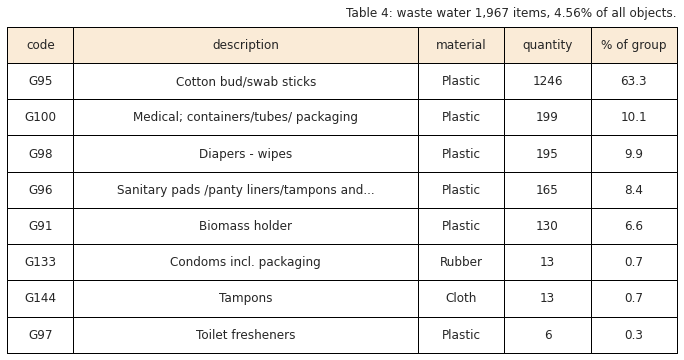

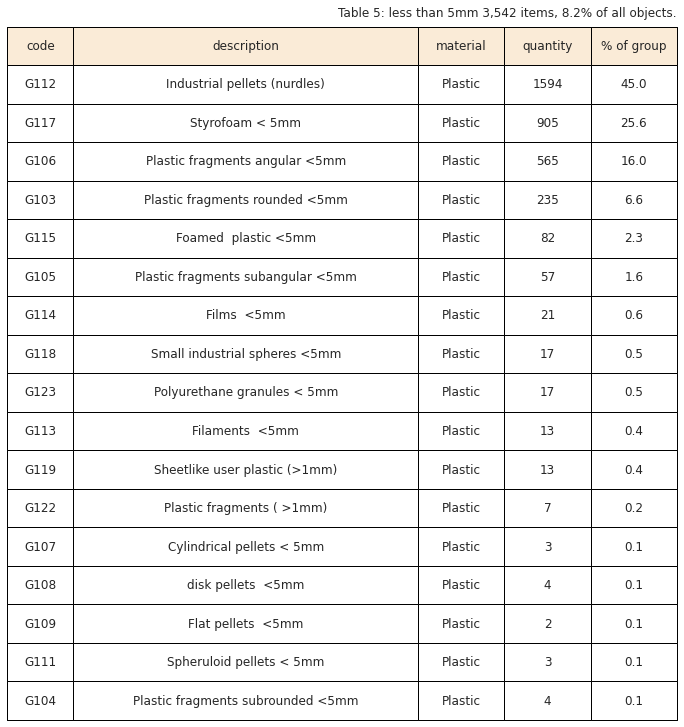

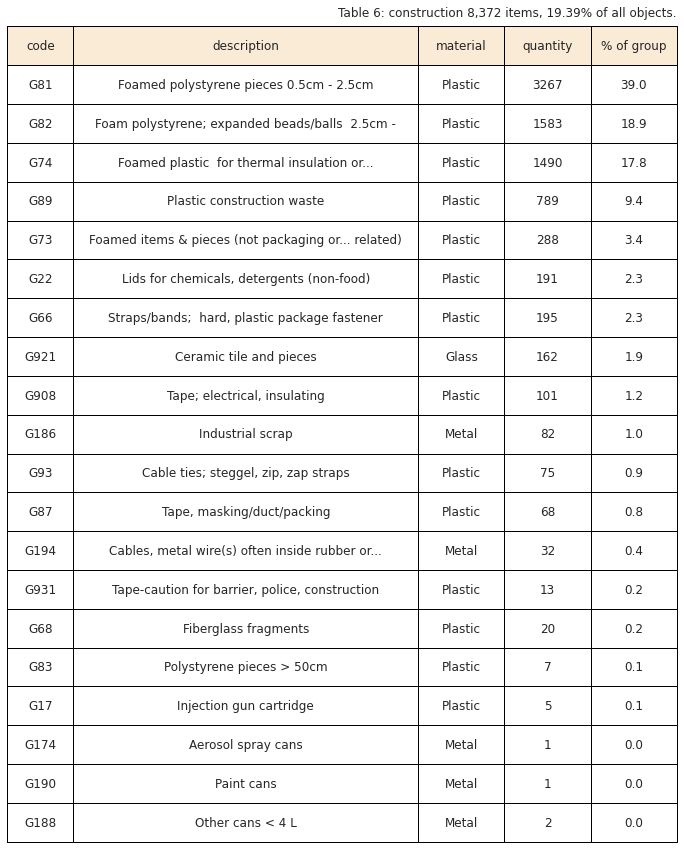

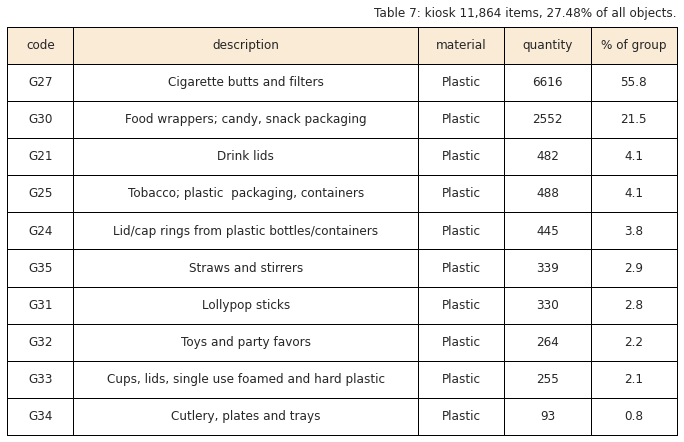

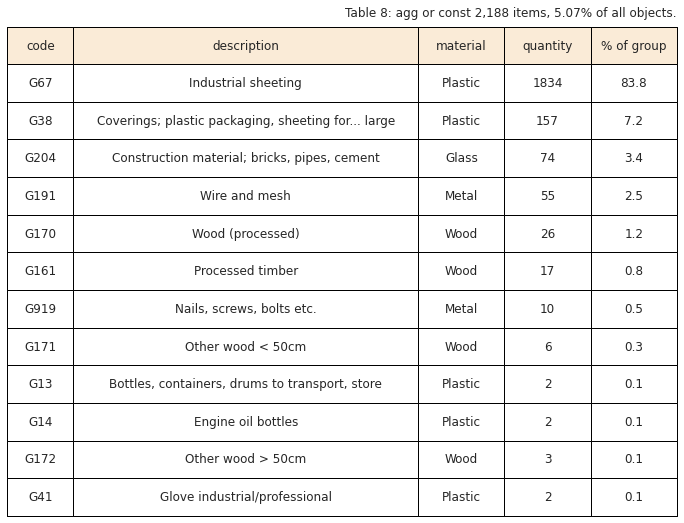

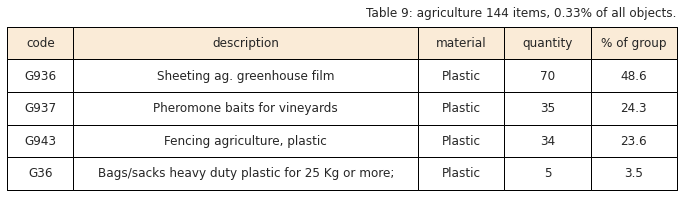

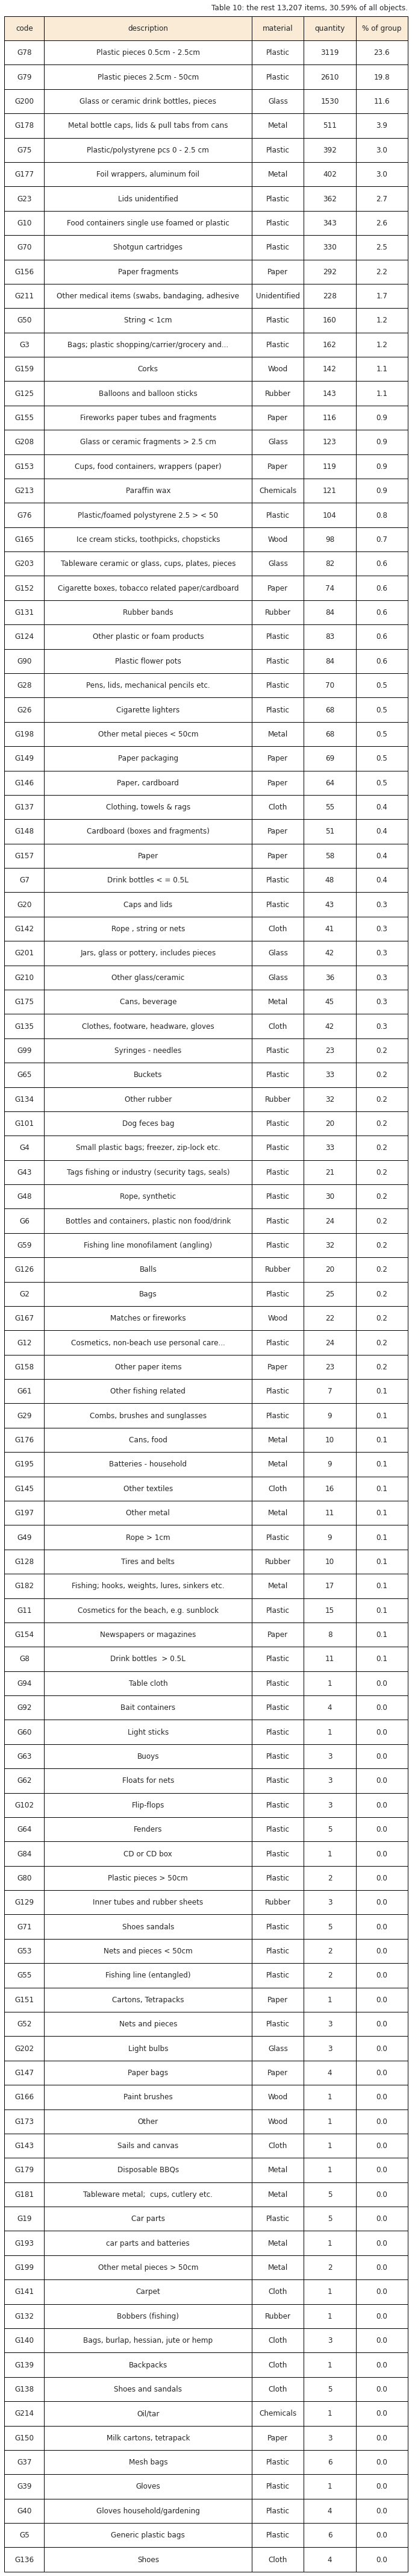

In [27]:
def make_this_astring(df, somnums):
    for i in somnums:
        print("{}. {code}: {description}".format(i+1, **df.iloc[i]))
# count_k(dfCodes.loc[x].description, limit)

# context:

french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité'}
thing = 'objets'
parent = "de l'ensemble"


groupTotals = {}
for name in group_names:
    somdata = groupdfs[name].copy()
    somdata = somdata[somdata.quantity > 0]
    newdata = somdata.groupby('code').agg({'quantity':'sum', 'pcs_m':'mean'})
    somdatatot = somdata.quantity.sum()
    newdata['% of group']=np.round((newdata.quantity/somdatatot)*100, 1)
    # check context
    if is_french:
        newdata['description'] = newdata.index.map(lambda x: count_k(fr_defs_codes[x], limit))
    else:
        # do it in english
        newdata['description'] = newdata.index.map(lambda x: count_k(dfCodes.loc[x].description, limit))
        
    newdata['material'] = newdata.index.map(lambda x: dfCodes.loc[x].material)
    newdata.reset_index(inplace=True)
    
    newdata.drop('pcs_m', axis=1, inplace=True)
    newdata = newdata[['code','description', 'material', 'quantity', '% of group']]
    newdata.sort_values(by='% of group', ascending=False, inplace=True)
    groupTotals.update({name:newdata})


tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[10,52, 13, 13, 13], cellLoc='center')
a_total = groupdfs["survey total_dt"].quantity.sum()

for i,name in enumerate(group_names):
    somdata = groupTotals[name]
    
    # get the number of records
    somnums = np.arange(len(somdata))
    
    # get the total for the group
    group_total = somdata.quantity.sum()
    
    # check context before exporting:
    if is_french:
        # makes the column headers to desired language:
        somdata.rename(columns=french_columns, inplace=True)
    
    fig, axs = plt.subplots(figsize=(12, len(somdata)*.75))    
    a_table = mpl.table.table(
        cellText=somdata.values,
        colLabels=list(somdata.columns),
        colColours=['antiquewhite' for i in list(somdata.columns)],
        
        ax=axs,
        **tablecenter_k)
    axs.add_table(a_table)
    table_fonts(a_table, size=12)
    make_table_grids(axs)
    axs.tick_params(**tabtickp_k)
    # check context, the name is used to iterate so:
    if is_french:
        axs.set_title(F"Table {table_num}: {french_names[name]} {'{:,}'.format(group_total)} {thing}, {np.round((group_total/a_total)*100, 2)}% {parent}.", **titler_k)
    else:
        # do it in english
        axs.set_title(F"Table {table_num}: {name} {'{:,}'.format(group_total)} items, {np.round((group_total/a_total)*100, 2)}% of all objects.", **titler_k)
    figname = F"table{table_num}.jpg"
    tag = F"{name} component codes"
    
    add_output(figname, tag, fignum=table_num)
    table_num += 1

    
        

In [28]:
if is_french:
    sommarkdown = """### <span style="color:#1e90ff">Rrésultats par groupe de codes</span>\n#### <span style="color:#008891">résultats mensuels médians</span>\n
    """

else:
    sommarkdown = """### <span style="color:#1e90ff">Survey results per code group</span>\n#### <span style="color:#008891">Median monthly survey results</span>\n
    """

In [29]:
display(Markdown(sommarkdown))

### <span style="color:#1e90ff">Survey results per code group</span>
#### <span style="color:#008891">Median monthly survey results</span>

    

In [30]:
monthly_median = {}
for name in dt_names:
    somdata = groupdfs[name].copy()
    somdata.set_index('date', inplace=True)
    monthly = pd.DataFrame(somdata.resample('M').pcs_m.median())
    monthly['change'] = monthly.pcs_m.diff()
    monthly['change'] = monthly['change'].round(4)
    monthly.fillna(0, inplace=True)
    monthly_median.update({name:[monthly, somdata]})


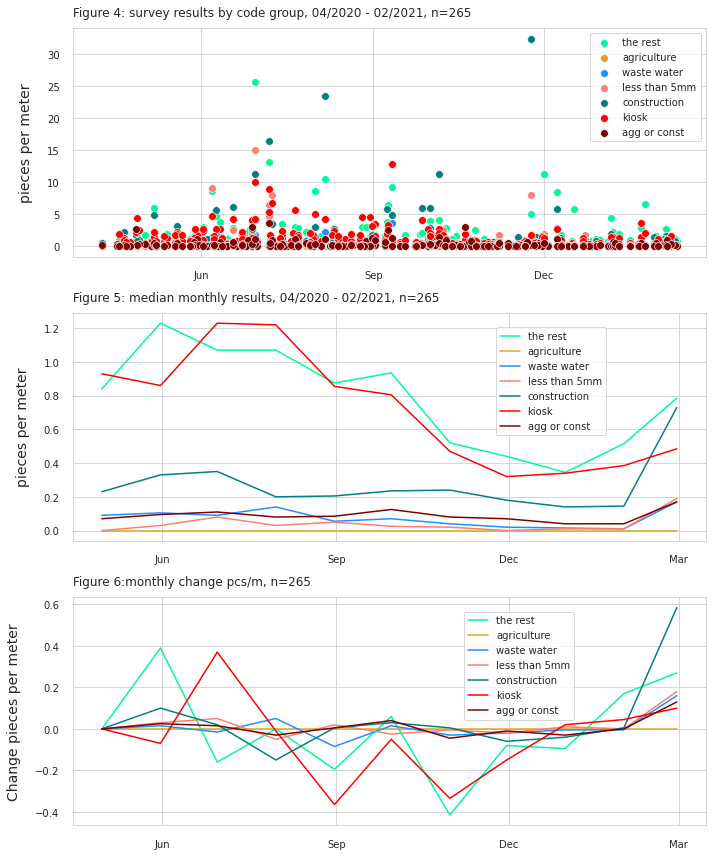

In [31]:
# context:
# is_french = False
# is_german = False
# is_italian = False

french_columns = {'code':'code','description': 'description', 'material':'matériel', 'quantity':'quantité'}
thing = 'objets'
parent = "de l'ensemble"
french_pcm = "pièces par mètre"
french_srs = "résultats des recensements"
french_pcg = "par groupe de codes"
french_med = "médian"
french_mm = "médiane mensuelle"
french_change = 'changement'

fig, axs = plt.subplots(3,1,figsize=(10,12))

# not charting the survey total here:

listofgroups = list(monthly_median.keys())
listofgroups.remove('survey total_dt')
listofgroups.remove('the rest_dt')
listofgroups.remove('agriculture_dt')
inorder =  ['the rest_dt','agriculture_dt', *listofgroups]

    
for i,name in enumerate(inorder):
    data = monthly_median[name][1]
    if is_french:
        sns.scatterplot(data=data, x=data.index,  y='pcs_m', label=french_names[name[:-3]], color=grouppalette[name[:-3]], alpha=1,s=60, ax=axs[0])
    else:
        sns.scatterplot(data=data, x=data.index,  y='pcs_m', label=name[:-3], color=grouppalette[name[:-3]], alpha=1,s=60, ax=axs[0])
for i,name in enumerate(inorder):
    data = monthly_median[name][0]
    if is_french:
        sns.lineplot(data=data, x=data.index,  y='pcs_m', label=french_names[name[:-3]], color=grouppalette[name[:-3]], ax=axs[1])
    else:
        sns.lineplot(data=data, x=data.index,  y='pcs_m', label=name[:-3], color=grouppalette[name[:-3]], ax=axs[1])
for i,name in enumerate(inorder):
    data = monthly_median[name][0]
    if is_french:
        sns.lineplot(data=data, x=data.index,  y='change', label=french_names[name[:-3]], color=grouppalette[name[:-3]], ax=axs[2])
    else:
        sns.lineplot(data=data, x=data.index,  y='change', label=name[:-3], color=grouppalette[name[:-3]], ax=axs[2])
axs[0].xaxis.set_minor_locator(weeks)
axs[0].xaxis.set_major_formatter(mths_fmt)
axs[0].xaxis.set_major_locator(months)
axs[0].tick_params(which='major', pad=10)
axs[0].set_xlabel("")

if is_french:
    axs[0].set_ylabel(french_pcm, **ylab_k)
else:
    axs[0].set_ylabel("pieces per meter", **ylab_k)
    
labels, handles = axs[0].get_legend_handles_labels()
axs[0].legend(labels, handles, loc='best')
if is_french:
    axs[0].set_title(F"Figure {figure_num}:{french_srs} {french_pcg}, {startyearmonth} - {endyearmonth}, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1
    axs[1].set_title(F"Figure {figure_num}:{french_mm} {french_srs}, {startyearmonth} - {endyearmonth}, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1
    axs[2].set_title(F"Figure {figure_num}:changement {french_mm} pcs/m, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1
else:
    axs[0].set_title(F"Figure {figure_num}: survey results by code group, {startyearmonth} - {endyearmonth}, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1
    axs[1].set_title(F"Figure {figure_num}: median monthly results, {startyearmonth} - {endyearmonth}, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1
    axs[2].set_title(F"Figure {figure_num}:monthly change pcs/m, n={len(groupdfs['survey total_dt'])}", **title_k)
    figure_num += 1


axs[1].xaxis.set_minor_locator(weeks)
axs[1].xaxis.set_major_formatter(mths_fmt)
axs[1].xaxis.set_major_locator(months)
axs[1].tick_params(which='major', pad=10)
axs[1].set_xlabel("")
if is_french:
    axs[1].set_ylabel(french_pcm, **ylab_k)
else:
    axs[1].set_ylabel("pieces per meter", **ylab_k)
labels, handles = axs[1].get_legend_handles_labels()
axs[1].legend(labels, handles, bbox_to_anchor=(0.85, .7),loc='right')
figure_num +=1

axs[2].xaxis.set_minor_locator(weeks)
axs[2].xaxis.set_major_formatter(mths_fmt)
axs[2].xaxis.set_major_locator(months)
axs[2].tick_params(which='major', pad=10)
axs[2].set_xlabel("")
if is_french:
    axs[2].set_ylabel(F"{french_change}", **ylab_k)
else:
    axs[2].set_ylabel("Change pieces per meter", **ylab_k)
labels, handles = axs[2].get_legend_handles_labels()
axs[2].legend(labels, handles,bbox_to_anchor=(0.8, .7),loc='right')

plt.tight_layout()

figname = "fig5_6_and7.jpg"
tag = F"code group survey results, montlhy median and change"
atype='figure'
add_output(figname, tag, fignum=figure_num, atype=atype)


plt.show()
plt.close()

In [32]:
#### <span style="color:#008891">Key values per code group</span>

if is_french:
    sommarkdown = """#### <span style="color:#008891">Valeurs clés par groupe de code</span>
    """
else:    
    sommarkdown = """#### <span style="color:#008891">Key values per code group</span>
    """

In [33]:
display(Markdown(sommarkdown))

#### <span style="color:#008891">Key values per code group</span>
    

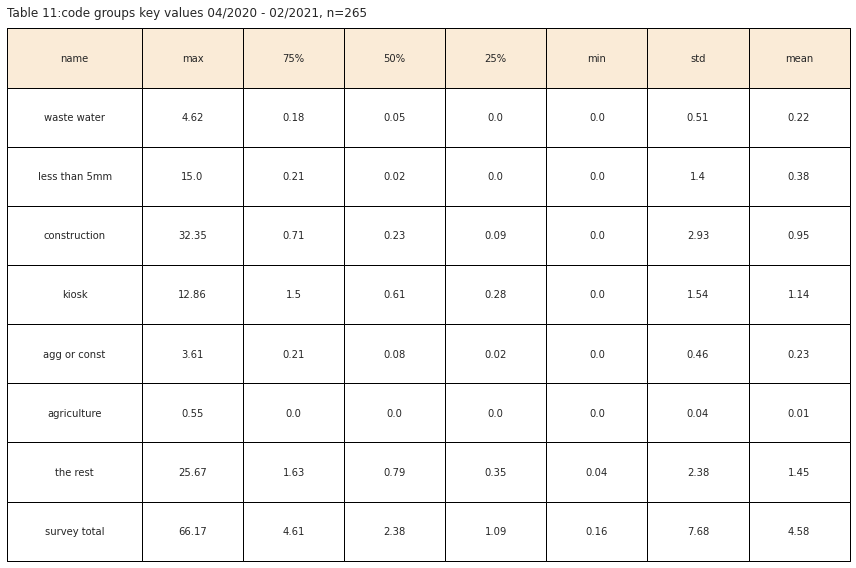

In [34]:

# sum_tables[2]['data']
sum_tables = []
for name in dt_names:
    a_row = list(groupdfs[name].pcs_m.describe().index[1:])
    a_data = {i:np.round(groupdfs[name].pcs_m.describe()[i], 2) for i in a_row}
    a_data.update({'name':name[:-3]})
    a_data
    sum_tables.append(a_data)
sum_tables = pd.DataFrame(sum_tables)
sum_tables = sum_tables[sum_tables.columns[::-1]]
col_widths = [16,12,12,12,12,12,12,12 ]
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=col_widths, cellLoc='center')
fig, axs = plt.subplots(figsize=(12,len(sum_tables)))

a_table = mpl.table.table(
    cellText=sum_tables.values,
#             rowLabels=sum_tables.values,
            colLabels=sum_tables.columns,
            colColours=['antiquewhite' for i in sum_tables.columns],
#             rowColours=['antiquewhite' for i in np.arange(len(table['a_row']))],
            ax=axs,
            **tablecenter_k)
make_table_grids(axs)
axs.add_table(a_table )
axs.tick_params(**tabtickp_k)
axs.set_title(F"Table {table_num}:code groups key values {startyearmonth} - {endyearmonth}, n={len(groupdfs['survey total_dt'])} ", **title_k)
figname = F"table{table_num}"
fignum = table_num
table_num += 1
    
plt.tight_layout()

tag = F"code groups key values"
add_output(figname, tag, fignum=fignum)
plt.box(on=None)
plt.show()
plt.close()

### <span style="color:#1e90ff"> Project lakes: significant events by code group and lake</span>

**Definition of significant event**: a significant event is defined as a survey result that exceeds the 90th percentile of all surveys for that code group. In this report the 90th percentile is considered for all surveys in the project lakes.

In [35]:

# significant values
# use the ECDF method from statsmodels to get the ecdf function for the different data frames
# get a point estimate for each survey from the ecdf
# determine wether or not the event was greater than the 90th percentile
# a parallel method in numpy is used to chekc the results
# pieces per meter
pmecdfs = {}
for name in dt_names:
    somdata = groupdfs[name]
    thisecdf = ECDF(somdata['pcs_m'])
    pmecdfs.update({name:thisecdf})
    somdata['p_dt'] = somdata.pcs_m.map(lambda x: 1-thisecdf(x))
    somdata['np90'] = np.percentile(somdata.pcs_m.values, 90)
    somdata['significant'] = somdata.p_dt.map(lambda x: x <= one_minus_sig)
    
ptecdfs = {}
for name in dt_names:
    somdata = groupdfs[name]
    thisecdf = ECDF(somdata['p_total'])    
    ptecdfs.update({name:thisecdf})
    somdata['p_pt'] = somdata.p_total.map(lambda x: 1-thisecdf(x))
    somdata['np90'] = np.percentile(somdata.pcs_m.values, 90)
    somdata['significant_p'] = somdata.p_pt.map(lambda x: x <= one_minus_sig)

events_data = {}
for name in dt_names:
    somdata = groupdfs[name]
    p_dt90 = somdata[somdata.significant == True].groupby(['water_name'], as_index=False).loc_date.nunique()
    p_dt90['frequency'] = p_dt90.water_name.map(lambda x: (F"{p_dt90.loc[p_dt90.water_name == x]['loc_date'].values[0]}/{regional_summary.loc[regional_summary.lake == x]['# samples'].values[0]}"))
    p_dt90.rename(columns={'loc_date':'# significant','water_name': 'lake'}, inplace=True)
    events_data.update({name:p_dt90})


In [36]:
c = groupdfs['waste water_dt'].copy()
# print(c.columns)
th90th = np.percentile(c.pcs_m.values, 90)
c['s'] = c.pcs_m.map(lambda x: x >= th90th) 
# print(th90th)
# c['s'].sum()

# c['test']=c.pcs_m >= c.np90

In [37]:
somcols = ['lake', '# locations', '# with', '# samples', '# samps with', 'median pcs/m', 'mean pcs/m', '% of daily total']

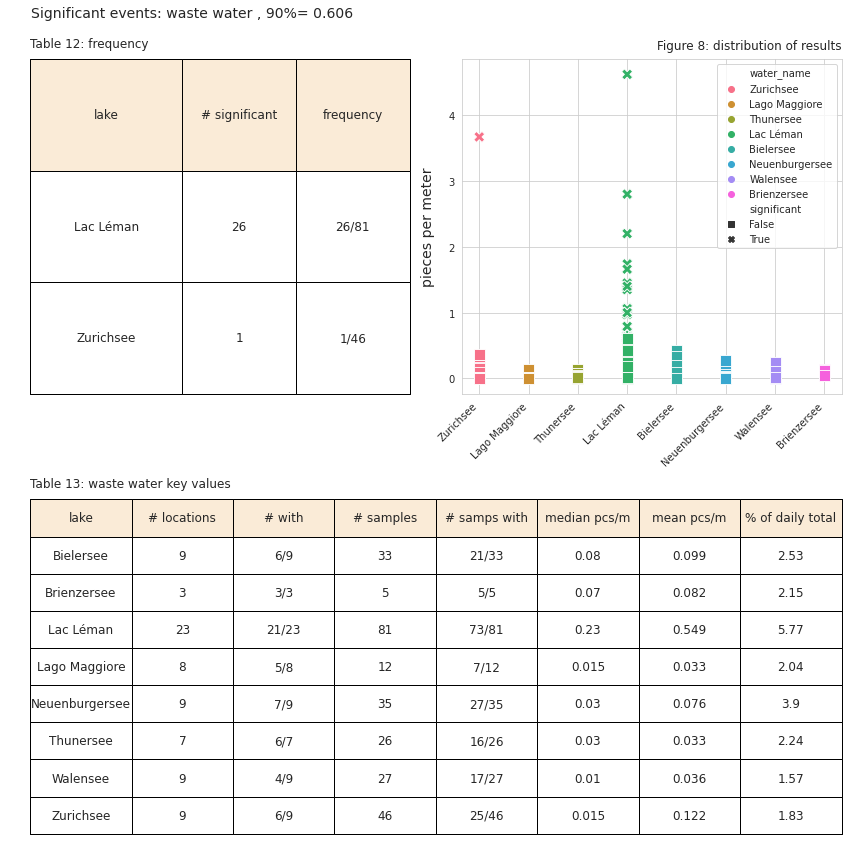

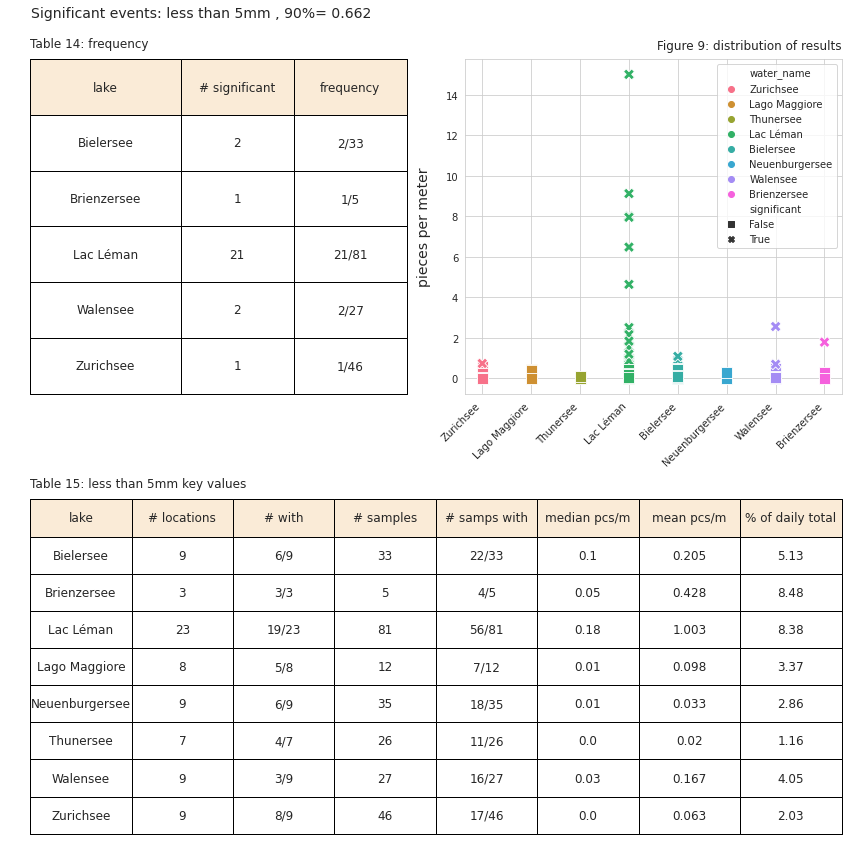

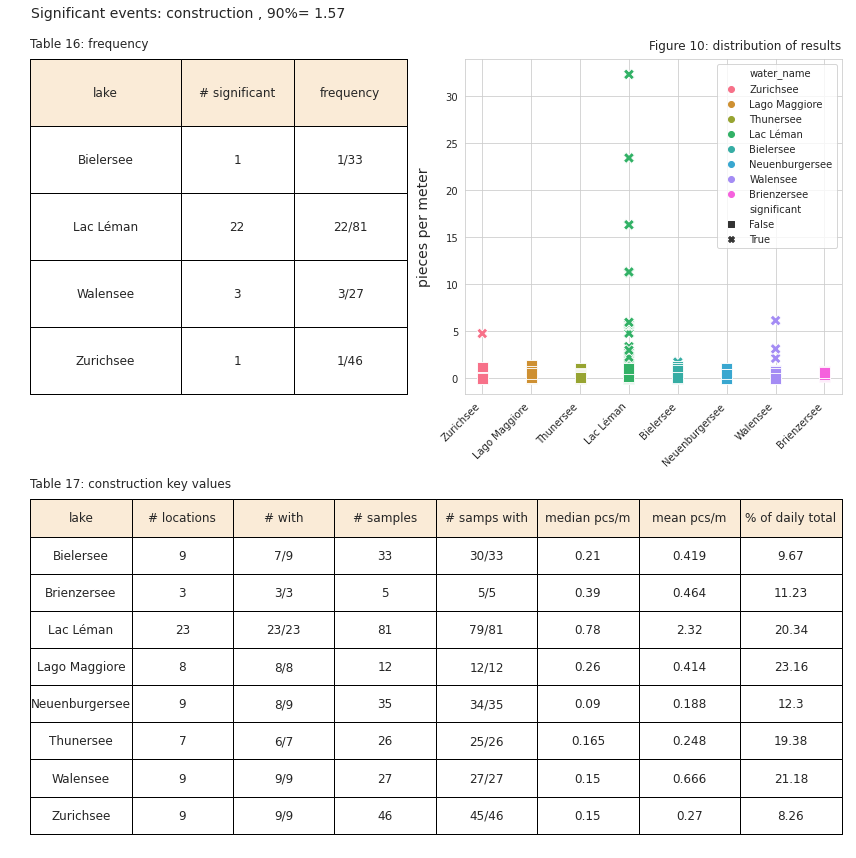

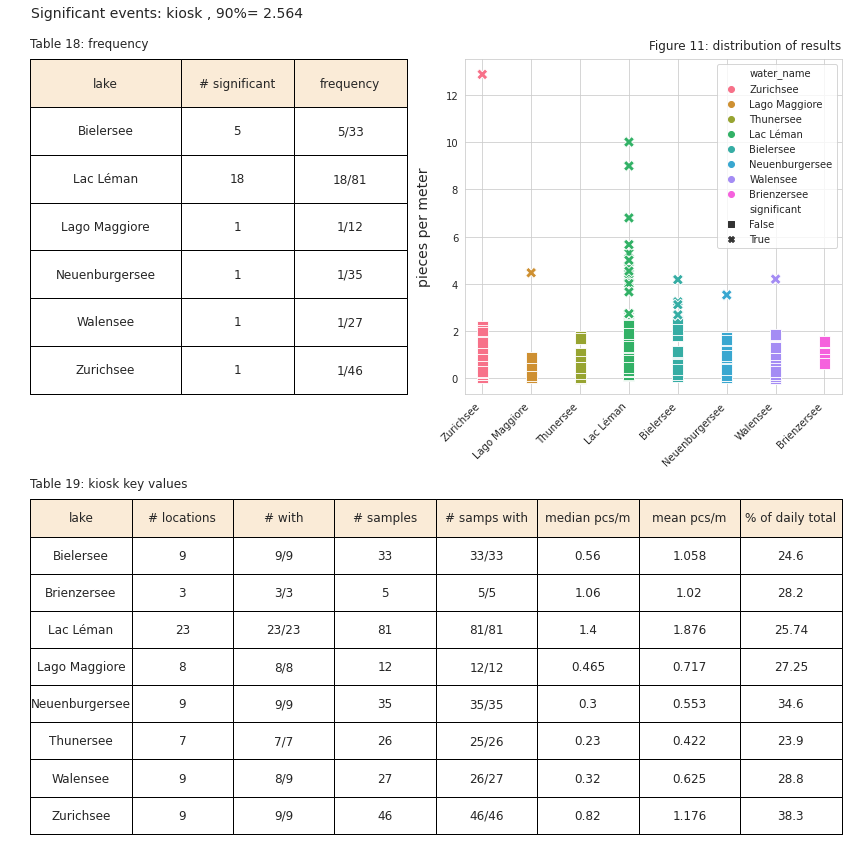

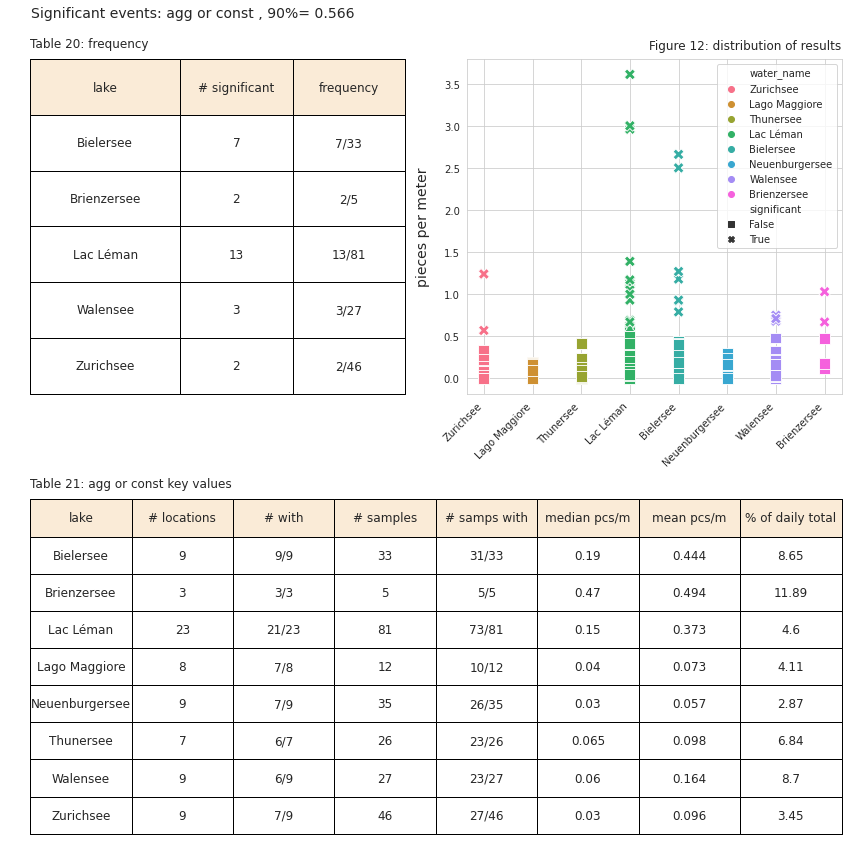

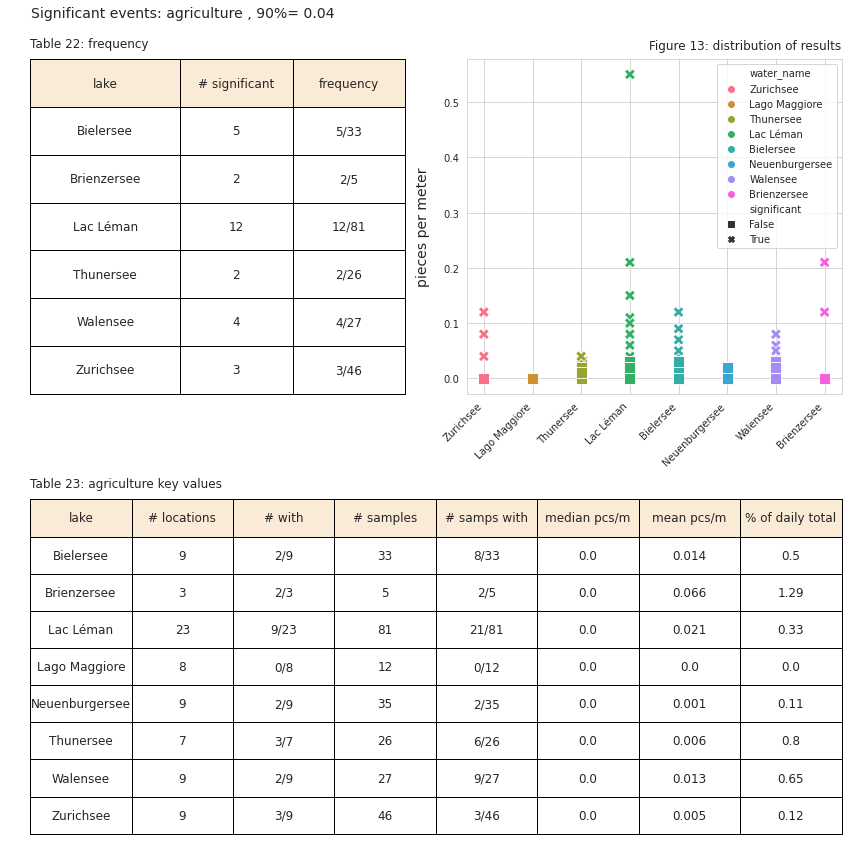

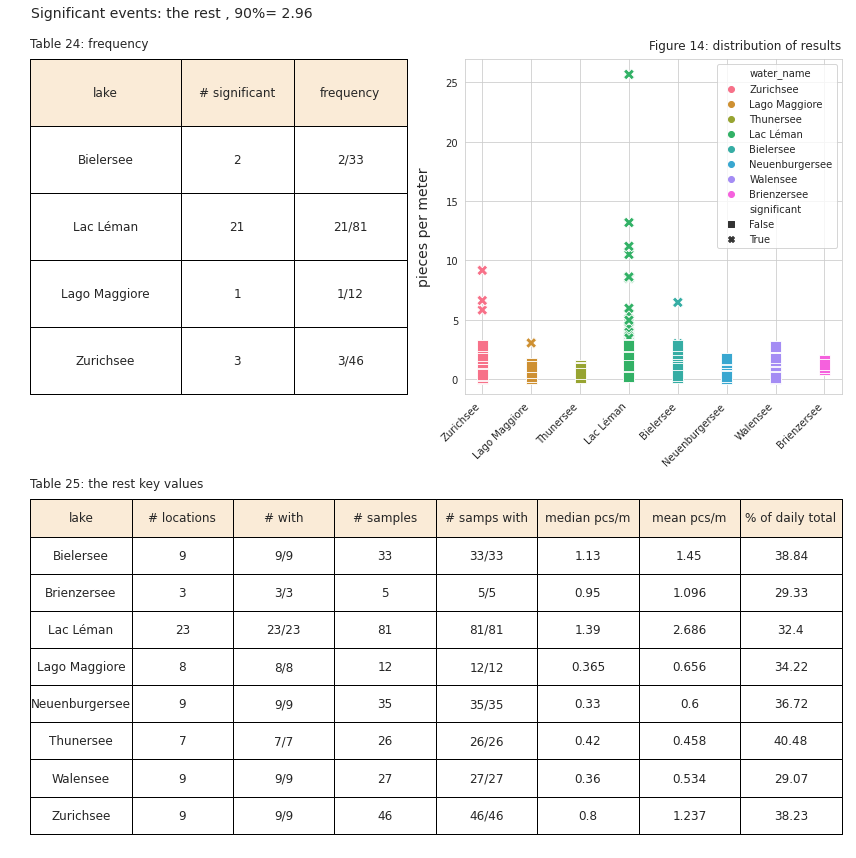

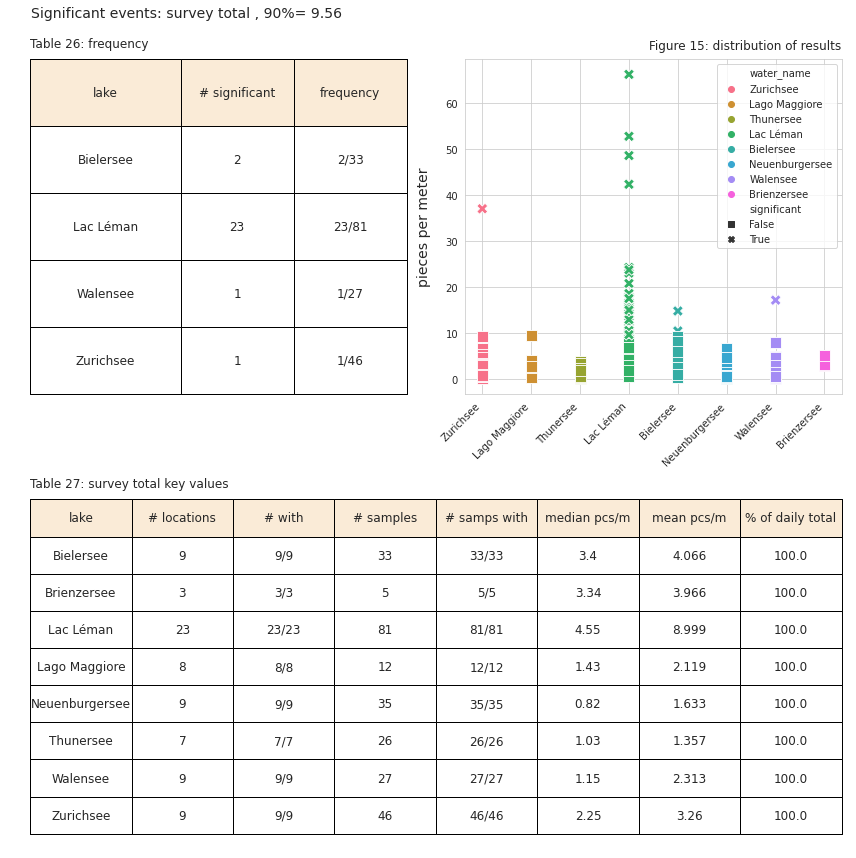

In [38]:
# sns.set_style('whitegrid')
# événement significatif

tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12, colWidths = [0.4, 0.3, 0.3])
# tablecenter_k.update({'bbox':(0,0,1, 1)})
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)
for i,name in enumerate(dt_names):
    event_data = events_data[name][['lake', '# significant', 'frequency']]
    if is_french:
        event_data = event_data.rename(columns={'lake':'lac', '# significant':'# significatif', 'frequency':'fréquence'})
        
        
    with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):
        fig, axs = plt.subplots(figsize=(12,12), frameon=False)
        sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)

    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    make_table_grids(ax1)

    

    a_table = ax1.add_table(mpl.table.table(
        cellText=event_data.values,
        colLabels=event_data.columns,
        colColours=['antiquewhite' for col in event_data.columns],
        ax=ax1,
        **tablecenter_k))


    table_fonts(a_table)

    ax1.tick_params(**tabtickp_k)
    the90th = groupdfs[name].np90.unique()[0]
    if is_french:
        ax1.set_title(F"Table {table_num}: fréquence", **title_k)
        
    else:
        ax1.set_title(F"Table {table_num}: frequency", **title_k)
    table_num += 1
    ax2 = fig.add_subplot(gs[0,1])
    with sns.axes_style('whitegrid',{'xtick.color':'black', 'ytick.color':'black'}):
        ax2 = sns.scatterplot(data=groupdfs[name],
                              x='water_name',
                              y='pcs_m',
                              hue='water_name',
                              style='significant',
                              s=120, 
                              palette='husl',
                              markers={True:'X', False:'s'}, ax=ax2)
        ax2.xaxis.set_tick_params(rotation=45)
        for tick in ax2.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("right")
        ax2.set_xlabel("")
        if is_french:
            ax2.set_ylabel(F"{french_pcm}", **ylab_k)
            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles, labels)
            ax2.set_title(F"Figure {figure_num}: distribution des résultats", **titler_k)       
        
        else:
            ax2.set_ylabel("pieces per meter", **ylab_k)
            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles, labels)
            ax2.set_title(F"Figure {figure_num}: distribution of results", **titler_k)
        figure_num += 1
    
    ax3 = fig.add_subplot(gs[1, 0:])
    a_table = ax3.add_table(mpl.table.table(cellText=regional_summaries[i]['data'] , colLabels=list(regional_summaries[i]['cols']),colColours=['antiquewhite' for col in list(regional_summaries[i]['cols'])], ax=ax3, **tablecenter_kx))
    make_table_grids(ax3)
    table_fonts(a_table)
    ax3.tick_params(**tabtickp_k)
    
    if is_french:
        ax3.set_title(F"Table {table_num}: valeurs clés", **title_k)
        plt.suptitle(F"Evénements significatifs: {french_sum_names[name[:-3]]}, 90%= {np.round(the90th, 3)}", ha='left', size=14, x=0.04, y=0.99)
    else:
        ax3.set_title(F"Table {table_num}: {name[:-3]} key values", **title_k)
        plt.suptitle(F"Significant events: {name[:-3]} , 90%= {np.round(the90th, 3)}", ha='left', size=14, x=0.04, y=0.99)
    figname=F"table{table_num}.jpg"
    table_num += 1
    plt.tight_layout()

    tag = F"{name[:-3]} significant events"
    atype='figure'
    add_output(figname, tag, fignum=figure_num, atype=atype)

    plt.show()
    plt.close()

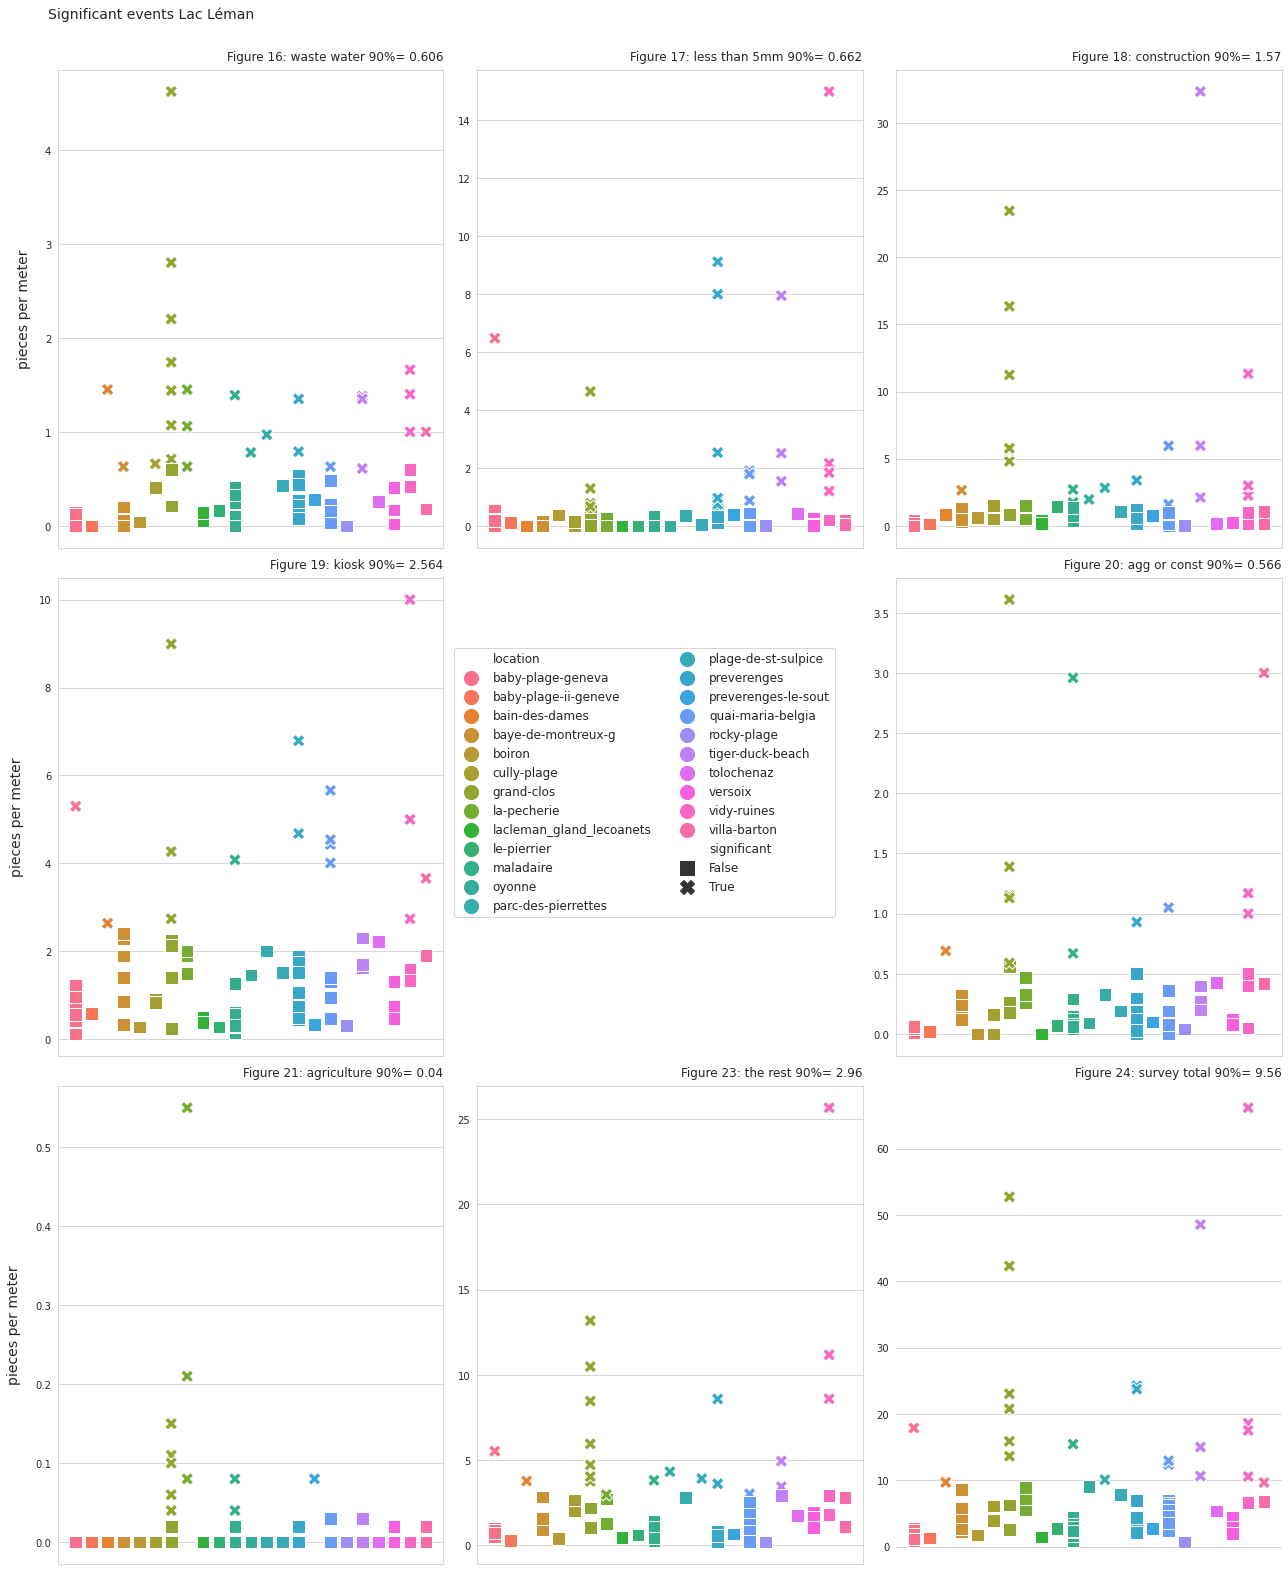

In [39]:
hmm = groupdconcat.copy()
barplotdata = hmm[hmm.water_name == lake].groupby('groupname').quantity.sum()
sns.set_style('whitegrid')
fig, axs = plt.subplots(3,3, figsize=(18, 22))
for i in np.arange(len(dt_names)+1):
    end = len(dt_names) -1
    
    
    
    if i<4:
        thisi = i
        thiscol = i%3
        name = dt_names[i]
        anax = axs[math.floor(i/3),thiscol]
        somdata = groupdfs[name]
        somdata = somdata[somdata.water_name == lake]
        thisplot = sns.scatterplot(
                data=somdata,
                x='location',
                y='pcs_m',
                hue='location',
                style='significant',
                s=160, ax=anax,
                palette='husl',
                markers={True:'X', False:'s'}
            )
        anax.get_legend().remove()
        
    if i > 4 and i <= end:
        thisi = i+1
        thiscol = thisi%3
        
        name = dt_names[i]
        anax = axs[math.floor(thisi/3),thiscol]
        somdata = groupdfs[name]
        somdata = somdata[somdata.water_name == lake]
        thisplot = sns.scatterplot(
                data=somdata,
                x='location',
                y='pcs_m',
                hue='location',
                style='significant',
                s=160, ax=anax,
                palette='husl',
                markers={True:'X', False:'s'}
            )
        if thiscol > 0:
            anax.set_ylabel("")
        anax.get_legend().remove()        
        
    if i == 4:
        thiscol = i%3
        
        anax = axs[math.floor(i/3),thiscol]
        anax.tick_params(**tabtickp_k)
        make_table_grids(anax)
        name = dt_names[i]
        anax = axs[math.floor((i+1)/3),(i+1)%3]
        somdata = groupdfs[name]
        somdata = somdata[somdata.water_name == lake]     
        
        
        thisplot = sns.scatterplot(
                data=somdata,
                x='location',
                y='pcs_m',
                hue='location',
                style='significant',
                s=160, ax=anax,
                palette='husl',
                markers={True:'X', False:'s'}
            )
        anax.get_legend().remove()
    if i >= end :
        thisi = i
        thiscol = thisi%3
        
        name = dt_names[i-1]
        anax = axs[math.floor(thisi/3),thiscol]
        somdata = groupdfs[name]
        somdata = somdata[somdata.water_name == lake]
        thisplot = sns.scatterplot(
                data=somdata,
                x='location',
                y='pcs_m',
                hue='location',
                style='significant',
                s=160, ax=anax,
                palette='husl',
                markers={True:'X', False:'s'}
            )
        if thiscol > 0:
            anax.set_ylabel("")
        handles, labels = anax.get_legend_handles_labels()
        anax.get_legend().remove() 
   
    
        
#     anax.xaxis.set_tick_params(rotation=45)
#     for tick in anax.xaxis.get_majorticklabels():
#         tick.set_horizontalalignment("right")
    anax.set_xticks([])
    anax.set_xlabel("")
    the90th = groupdfs[name].np90.unique()[0]
    if thiscol > 0:
            anax.set_ylabel("")
    else:
        anax.set_ylabel("pieces per meter", **ylab_k)
#     anax.legend(handles[9:], labels[9:])
    if is_french:
        anax.set_title(F"Figure {figure_num}: {french_sum_names[name[:-3]]} 90%= {np.round(the90th, 3)} ", **titler_k)
        
    else:
        anax.set_title(F"Figure {figure_num}: {name[:-3]} 90%= {np.round(the90th, 3)}", **titler_k)
    figure_num += 1

for handle in handles:
    handle.set_sizes([200])

#
fig.legend(handles[:27], labels[:27], bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2, fontsize=12)
figname = F"figure{figure_num}.jpg"

plt.suptitle(F"Significant events {lake}", ha='left', size=14, x=0.04, y=0.99)
# plt.suptitle(F"table 4: Key values {lake} survey results, n={len(leman_data['waste water_dt'])}", x=.5, y=1, ha='center', fontsize=(14))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
atype="figure"
tag = F"{lake} regional assessment"
add_output(figname,tag, fignum=figure_num, atype=atype)
plt.box(on=None)
plt.show()
plt.close()

### Figures and data produced by this notebook:



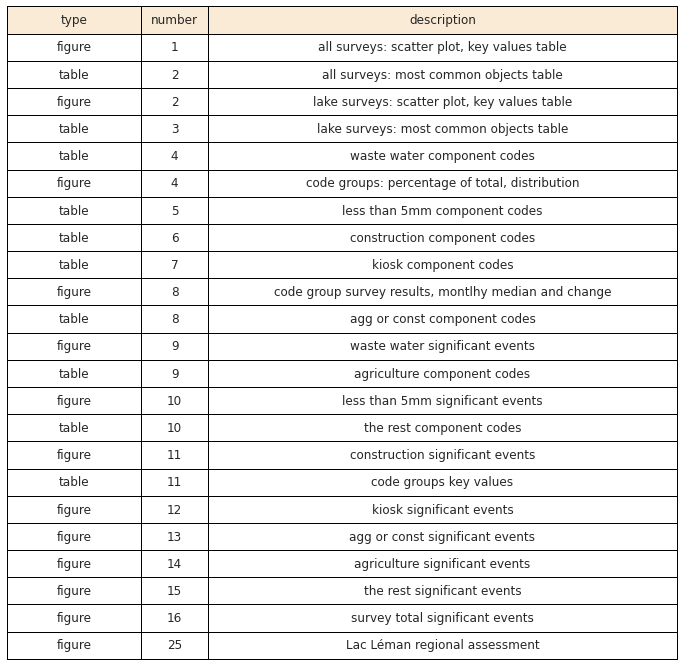

In [40]:
files_df = pd.DataFrame(files_generated[2:])
files_df.rename(columns={'tag':'description'}, inplace=True)

files_df = files_df[['type','number', 'description']]
files_df = files_df.sort_values(by='type')
files_df.sort_values(by='number', inplace=True)
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', colWidths=[20,10,70], fontsize=12)
# tablecenter_k.update({'bbox':(0,0,1, 1)})
tablecenter_kx = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center', fontsize=12)
# for i,name in enumerate(dt_names):
#     event_data = events_data[name][['lake', '# significant', 'frequency']]
#     if is_french:
#         event_data = event_data.rename(columns={'lake':'lac', '# significant':'# significatif', 'frequency':'fréquence'})
        
with sns.axes_style('white', {'xtick.color':'white', 'ytick.color':'white'}):
    fig, axs = plt.subplots(figsize=(12,12), frameon=False)
    sns.despine(fig=fig, top=True, left=True, right=True, bottom=True)
#   gs = GridSpec(2, 2, figure=fig)
#   ax1 = fig.add_subplot(gs[0,0])
    make_table_grids(ax1)

    

    a_table = axs.add_table(mpl.table.table(
        cellText=files_df.values,
        colLabels=files_df.columns,
        colColours=['antiquewhite' for col in files_df.columns],
        ax=axs,
        **tablecenter_k))


    table_fonts(a_table)

    axs.tick_params(**tabtickp_k)
#     the90th = groupdfs[name].np90.unique()[0]

In [41]:
def meters_for_one(pcs_m, qty):
    """calculates the number of meters for one piece"""
    try:
        meters_for_one = qty/pcs_m
    except:
        meters_for_one = 0
    return meters_for_one

In [42]:
somdata = groupdfs['survey total_dt'].copy()
somdata.set_index('loc_date', inplace=True)

In [43]:
somdata['length'] = somdata.quantity/somdata.pcs_m
lengthmap = somdata['length']

In [44]:
mordata = groupdfs['agg or const_dt'].copy()
mordata['length'] = mordata.loc_date.map(lambda x: lengthmap[x])
bldsmax = mordata.buildings.max()
bldsmin = mordata.buildings.min()
builds = mordata.buildings.unique()
quints = np.percentile(builds, [20, 40, 60, 80])
def mapquints(x, quints=quints):
    xnum = 0
    group = 0
    for i,quint in enumerate(quints):
        if x < quint:
            group = i+1
            break
    if group:
        pass
    if group == 0:
        if x >= max(quints):
            group=len(quints)+1
       
    return group
mordata['blds rank'] = mordata.buildings.map(lambda x: mapquints(x))

mordata.columns

Index(['loc_date', 'location', 'water_name', 'date', 'population', 'streets',
       'buildings', 'rivs', 'pop_builds', 'pop_streets', 'streets_builds',
       'groupname', 'pcs_m', 'quantity', 'p_total', 'p_dt', 'np90',
       'significant', 'p_pt', 'significant_p', 'length', 'blds rank'],
      dtype='object')

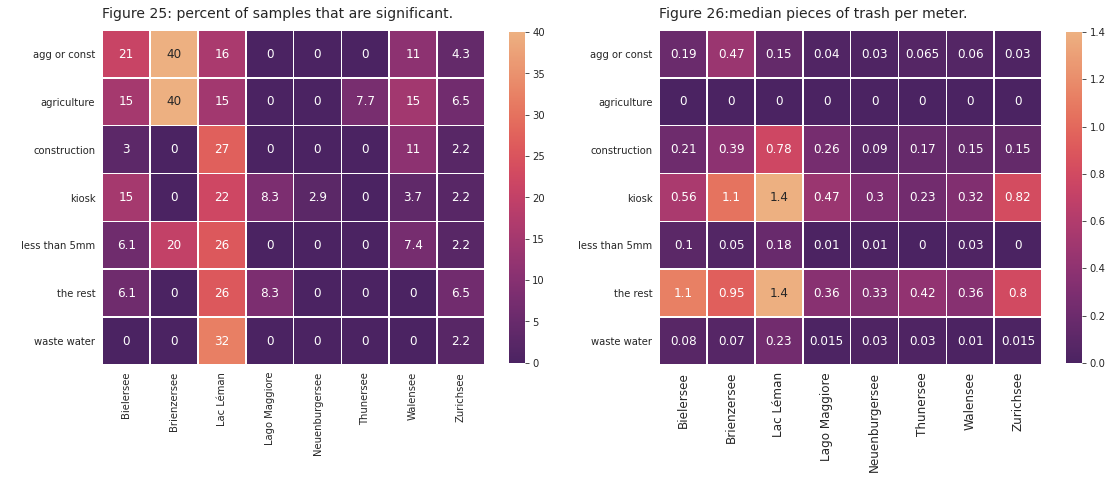

In [45]:
sigdf = pd.concat([groupdfs[dt_names[x]][['groupname', 'water_name', 'location', 'significant', 'p_total','loc_date', 'pcs_m']] for x in np.arange(len(dt_names[:-1]))])
sigdf['num samps'] = sigdf.water_name.map(lambda x: sigdf[sigdf.water_name == x].loc_date.nunique())
sigheat = sigdf.groupby(['water_name', 'groupname', 'num samps'], as_index=False).significant.sum()
sigheat['p_significant'] = sigheat.significant/sigheat['num samps']*100
sigheat['p_significant'] = sigheat['p_significant'].round(1)
hmm = sigheat.groupby(['water_name', 'groupname'], as_index=False).p_significant.median().pivot(columns='water_name', index='groupname')
hmmx = sigdf.groupby(['water_name', 'groupname'], as_index=False).pcs_m.median().pivot(columns='water_name', index='groupname')

fig,axx = plt.subplots(1,2, figsize=(16,8)) 

sns.heatmap(hmm,  cmap='flare_r', ax=axx[0], square=True, cbar_kws={"shrink": 0.65}, annot=True, annot_kws={'fontsize':12}, linewidths=.5)
labels = [a_text.get_text() for a_text in axx[0].get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[len('p_significant')+1:]
    newlabels.append(newlabel)

axx[0].set_xticklabels(newlabels)

axx[0].set_ylabel(" ")
axx[0].set_xlabel(" ")
ax[0].tick_params(axis='both', labelsize=12)
axx[0].set_title(F"Figure {figure_num}: percent of samples that are significant.", **title_k14)

sns.heatmap(hmmx, cmap='flare_r', ax=axx[1], square=True, cbar_kws={"shrink": 0.65}, annot=True, annot_kws={'fontsize':12},linewidths=.5)
axx[1].set_xticklabels(newlabels, fontsize=12)
axx[1].set_ylabel(" ")
axx[1].set_xlabel(" ")
ax[1].tick_params(axis='both', labelsize=12)
figure_num += 1
axx[1].set_title(F"Figure {figure_num}:median pieces of trash per meter.", **title_k14)
plt.tight_layout()

plt.show()

In [46]:
# sigdf = pd.concat([groupdfs[dt_names[x]][['groupname', 'water_name', 'location', 'significant', 'p_total','loc_date', 'pcs_m']] for x in np.arange(len(dt_names[:-1]))])
# sigdf['num samps'] = sigdf.water_name.map(lambda x: sigdf[sigdf.water_name == x].loc_date.nunique())

sigheat = sigdf[sigdf.water_name == lake].copy()
sigheatp = sigheat.groupby(['location', 'groupname', 'num samps'], as_index=False).significant.sum()
sigheatp['p_significant'] = sigheatp.significant/sigheatp['num samps']*100
sigheatp['p_significant'] = sigheatp['p_significant'].round(1)

hmm = sigheatp.groupby(['location', 'groupname'], as_index=False).p_significant.median().pivot(columns='location', index='groupname')
hmmx = sigheat.groupby(['location', 'groupname'], as_index=False).pcs_m.median().pivot(columns='location', index='groupname')

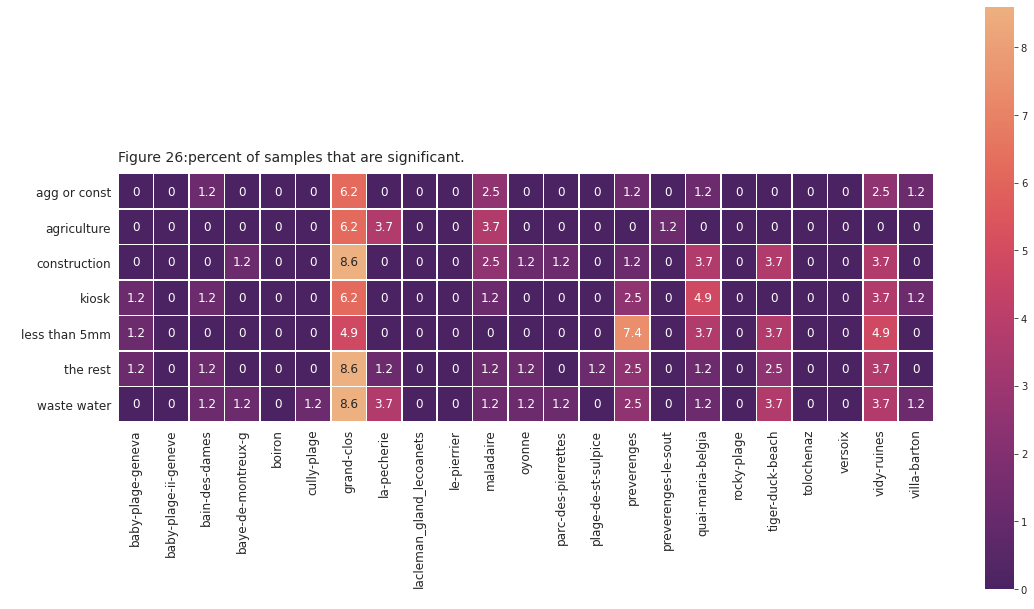

In [47]:

fig,axx = plt.subplots(figsize=(16,9)) 

sns.heatmap(hmm,  cmap='flare_r', ax=axx, square=True, annot=True,cbar_kws={"shrink": 1}, annot_kws={'fontsize':12}, linewidths=.5)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
newlabels = []
for i, a_text in enumerate(labels):
    oldlabel = a_text
    newlabel = oldlabel[len('p_significant')+1:]
    newlabels.append(newlabel)

axx.set_xticklabels(newlabels)

axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12)
axx.set_title(F"Figure {figure_num}:percent of samples that are significant.", **title_k14)


plt.tight_layout()

plt.show()

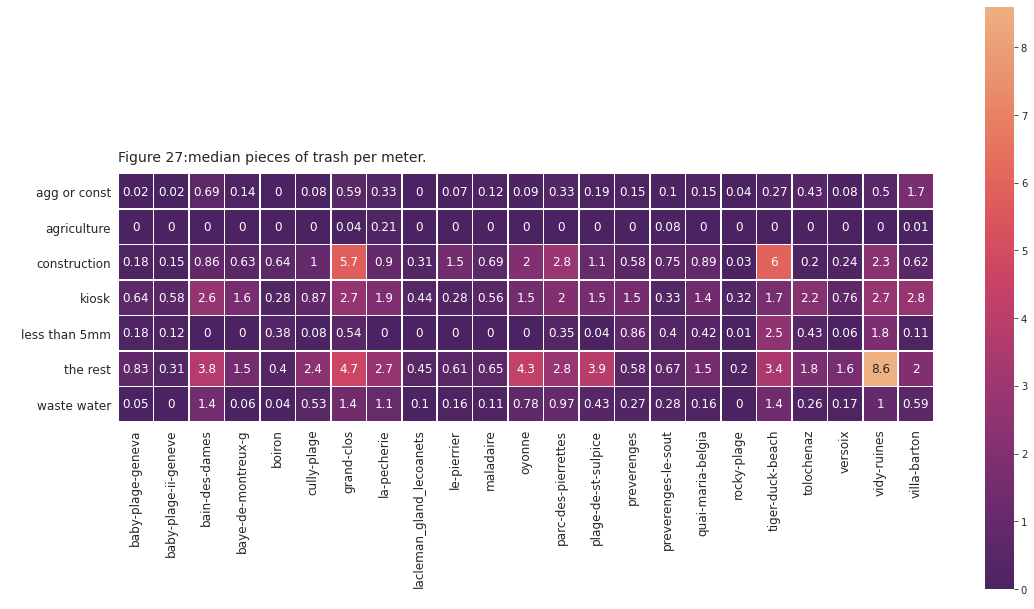

In [48]:
fig,axx = plt.subplots(figsize=(16,9)) 

sns.heatmap(hmmx,  cmap='flare_r', ax=axx, square=True, annot=True,cbar_kws={"shrink": 1}, annot_kws={'fontsize':12}, linewidths=.5)
labels = [a_text.get_text() for a_text in axx.get_xticklabels()]
axx.set_xticklabels(newlabels, fontsize=12)
axx.set_ylabel(" ")
axx.set_xlabel(" ")
axx.tick_params(axis='both', labelsize=12)
figure_num += 1
axx.set_title(F"Figure {figure_num}:median pieces of trash per meter.", **title_k14)
plt.tight_layout()
plt.show()

In [49]:
total_tries = mordata['length'].sum()
# number of items found
total_fails = mordata.quantity.sum()
# ratio of items found to meters walked
p = total_fails/total_tries

print(total_tries, total_fails)
print(F"P = {p}")

13777.237075417197 2188
P = 0.15881268414144234


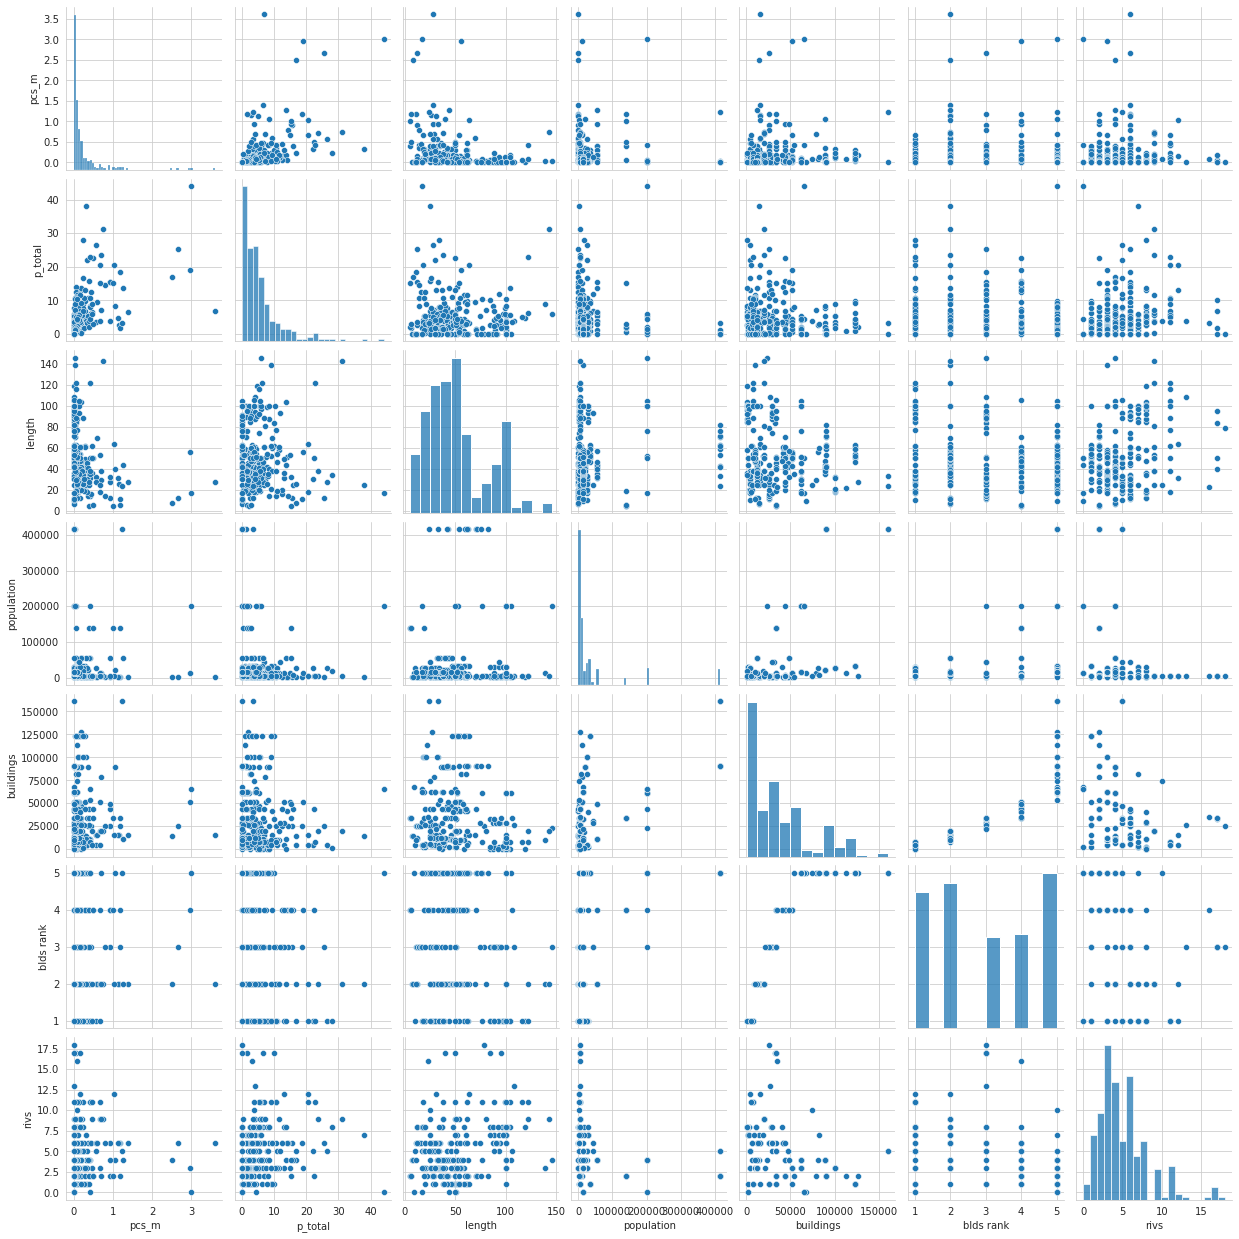

In [50]:
thesepairs = ['pcs_m','p_total', 'length','population', 'buildings','blds rank', 'rivs']

# mordata = mordata[mordata.population < 100000]
pairplots = mordata[thesepairs]

sns.pairplot(data=pairplots)

In [51]:
somdata['pcsx100'] = somdata.pcs_m * 100

In [52]:
fml="pcsx100 ~ population + buildings + rivs + streets"

In [53]:
somdata.isnull().describe()

,location,water_name,date,population,streets,buildings,rivs,pcs_m,quantity,p_total,p_dt,np90,significant,p_pt,significant_p,length,pcsx100
count,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265,265


In [54]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=somdata, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample()

NameError: name 'pm' is not defined

In [ ]:
groupdconcat

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch